# Telecom Churn Case Study

### Business Problem :-

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

In this case study, we will have to define high-value customers based on 70th percentile of the average recharge amount in the first two months and predict churn only on high-value customers.

In [1]:
### Loading the libraries and Data

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [4]:
from imblearn.over_sampling import SMOTE

In [5]:
#Reading the dataset

telecom = pd.read_csv("telecom_churn_data.csv")
telecom.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6  ...  sachet_3g_9  fb_user_6  fb_user_7  \
0            9/30/2014  197.385  ...            0        1.0        1.0   
1            9/30/2014   34.047  ...            0        NaN        1.0   
2            9/30/2014  167.690  ...            0        NaN        NaN   
3            9/30/2014  221.338  ...            0        NaN        NaN   
4            9/30/2014  261.636  ...            0        0.0        NaN   

   fb_user_8  fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  
0        1.0        NaN   968        30.4         0.0      101.20        3.58  
1        1.0        NaN  1006         0.0         0.0        0.00        0.00  
2        NaN        1.0  1103         0.0         0.0        4.17        0.00  
3        NaN        NaN  2491         0.0         0.0        0.00        0.00  
4        NaN        NaN  1526         0.0         0.0        0.00        0.00  

[5 rows x 226 columns]

In [3]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [4]:
telecom.shape

(99999, 226)

In [5]:
telecom.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

In [6]:
round(100*(telecom.isnull().sum()/len(telecom.index)), 2).sort_values(ascending = False)

count_rech_2g_6             74.85
date_of_last_rech_data_6    74.85
count_rech_3g_6             74.85
av_rech_amt_data_6          74.85
max_rech_data_6             74.85
                            ...  
last_day_rch_amt_6           0.00
last_day_rch_amt_7           0.00
last_day_rch_amt_8           0.00
last_day_rch_amt_9           0.00
mobile_number                0.00
Length: 226, dtype: float64

In [7]:
# Columns with more than 70% missing values
missing_cols = round(100*(telecom.isnull().sum()/len(telecom.index)), 2)
missing_cols[missing_cols >= 70]

date_of_last_rech_data_6    74.85
date_of_last_rech_data_7    74.43
date_of_last_rech_data_8    73.66
date_of_last_rech_data_9    74.08
total_rech_data_6           74.85
total_rech_data_7           74.43
total_rech_data_8           73.66
total_rech_data_9           74.08
max_rech_data_6             74.85
max_rech_data_7             74.43
max_rech_data_8             73.66
max_rech_data_9             74.08
count_rech_2g_6             74.85
count_rech_2g_7             74.43
count_rech_2g_8             73.66
count_rech_2g_9             74.08
count_rech_3g_6             74.85
count_rech_3g_7             74.43
count_rech_3g_8             73.66
count_rech_3g_9             74.08
av_rech_amt_data_6          74.85
av_rech_amt_data_7          74.43
av_rech_amt_data_8          73.66
av_rech_amt_data_9          74.08
arpu_3g_6                   74.85
arpu_3g_7                   74.43
arpu_3g_8                   73.66
arpu_3g_9                   74.08
arpu_2g_6                   74.85
arpu_2g_7     

Below columns can't be dropped though the missing values are greater than 70% because they are needed to derive the high value customers. So we need to impute them


-  total_rech_data_6 
-  total_rech_data_7 
-  av_rech_amt_data_6 
-  av_rech_amt_data_7 

As the above varibales are related to data recharge and they are having null values, that means the customers are not recharging for data. So we can impute them with Zero.

In [8]:
telecom.total_rech_data_6.fillna(value=0, inplace=True)
telecom.total_rech_data_7.fillna(value=0, inplace=True)
telecom.total_rech_data_8.fillna(value=0, inplace=True)
telecom.total_rech_data_9.fillna(value=0, inplace=True)

telecom.av_rech_amt_data_6.fillna(value=0, inplace=True)
telecom.av_rech_amt_data_7.fillna(value=0, inplace=True)
telecom.av_rech_amt_data_8.fillna(value=0, inplace=True)
telecom.av_rech_amt_data_9.fillna(value=0, inplace=True)

In [9]:
# Columns with more than 70% missing values
missing_cols = round(100*(telecom.isnull().sum()/len(telecom.index)), 2)
missing_cols[missing_cols >= 70]

date_of_last_rech_data_6    74.85
date_of_last_rech_data_7    74.43
date_of_last_rech_data_8    73.66
date_of_last_rech_data_9    74.08
max_rech_data_6             74.85
max_rech_data_7             74.43
max_rech_data_8             73.66
max_rech_data_9             74.08
count_rech_2g_6             74.85
count_rech_2g_7             74.43
count_rech_2g_8             73.66
count_rech_2g_9             74.08
count_rech_3g_6             74.85
count_rech_3g_7             74.43
count_rech_3g_8             73.66
count_rech_3g_9             74.08
arpu_3g_6                   74.85
arpu_3g_7                   74.43
arpu_3g_8                   73.66
arpu_3g_9                   74.08
arpu_2g_6                   74.85
arpu_2g_7                   74.43
arpu_2g_8                   73.66
arpu_2g_9                   74.08
night_pck_user_6            74.85
night_pck_user_7            74.43
night_pck_user_8            73.66
night_pck_user_9            74.08
fb_user_6                   74.85
fb_user_7     

Below features are having two categories and having more than 70% missing values. Let's impute the missing values with another new category.


-  night_pck_user_6            
-  night_pck_user_7            
-  night_pck_user_8           
-  night_pck_user_9          
-  fb_user_6                 
-  fb_user_7                 
-  fb_user_8
-  fb_user_9

In [10]:
user_vars = ["night_pck_user_6", "night_pck_user_7", "night_pck_user_8", 
"night_pck_user_9", "fb_user_6", "fb_user_7", "fb_user_8", "fb_user_9"]

for var in user_vars:
    telecom[var].fillna(value=-1, inplace=True)

In [11]:
# Dropping the missing values
drop_missing_cols = missing_cols[missing_cols > 70].index
telecom.drop(drop_missing_cols, axis=1, inplace=True)

In [12]:
round(100*(telecom.isnull().sum()/len(telecom.index)), 2).sort_values(ascending = False)

loc_ic_t2f_mou_9     7.75
spl_ic_mou_9         7.75
std_ic_t2f_mou_9     7.75
std_ic_mou_9         7.75
roam_og_mou_9        7.75
                     ... 
total_rech_data_6    0.00
total_rech_data_7    0.00
total_rech_data_8    0.00
total_rech_data_9    0.00
mobile_number        0.00
Length: 194, dtype: float64

In [13]:
telecom.shape

(99999, 194)

In [14]:
# Let's find the highly skewed columns

unique_value_cols = pd.DataFrame(telecom.nunique()).reset_index().rename(columns = {'index': 'feature', 0: 'nunique'})
unique_value_cols[unique_value_cols ['nunique'] == 1]

#print('%d features with a single unique value.\n' % len(unique_stats[unique_stats['nunique'] == 1]))

feature  nunique
1               circle_id        1
2          loc_og_t2o_mou        1
3          std_og_t2o_mou        1
4          loc_ic_t2o_mou        1
5    last_date_of_month_6        1
6    last_date_of_month_7        1
7    last_date_of_month_8        1
8    last_date_of_month_9        1
61       std_og_t2c_mou_6        1
62       std_og_t2c_mou_7        1
63       std_og_t2c_mou_8        1
64       std_og_t2c_mou_9        1
113      std_ic_t2o_mou_6        1
114      std_ic_t2o_mou_7        1
115      std_ic_t2o_mou_8        1
116      std_ic_t2o_mou_9        1

In [15]:
#Let's remove all the above 13 features.

telecom = telecom.drop(columns = list(unique_value_cols[unique_value_cols['nunique'] == 1]['feature']))
telecom.shape

(99999, 178)

### Filter high-value customers

As we need to predict churn only for the high-value customers. Define high-value customers as follows:

Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

Here recharge amount would be calling Recharge amount plus Recharge amount for Data. So, we need to consider both the amounts when calculating the percentile of the average recharge amount.

`total_rech_data_6` is number of times for Data recharge and `av_rech_amt_data_6` is average amount of data recharge. If we multiply both of these, we will get the total amount for data recharge.

Once we get the total amount for data recharge, we can find the average of this amount and `total_rech_amt_6` which is for noraml call recharge.

In [16]:
telecom['total_data_amt_6'] = telecom['total_rech_data_6'] * telecom['av_rech_amt_data_6']
telecom['total_data_amt_7'] = telecom['total_rech_data_7'] * telecom['av_rech_amt_data_7']

telecom['call_data_6'] = telecom[['total_rech_amt_6','total_data_amt_6']].sum(axis=1)
telecom['call_data_7'] = telecom[['total_rech_amt_7','total_data_amt_7']].sum(axis=1)

telecom['avg_rech_amt_6_7'] = telecom[['call_data_6','call_data_7']].mean(axis=1)

In [17]:
# Let's extract the high value customers which is 70th percentile of the average recharge amount 
#in the first two months. 

telecom = telecom[(telecom['avg_rech_amt_6_7'] >= telecom['avg_rech_amt_6_7'].quantile(0.7))]
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Columns: 183 entries, mobile_number to avg_rech_amt_6_7
dtypes: float64(145), int64(34), object(4)
memory usage: 42.1+ MB


In [18]:
# We can drop total_rech_data_* and av_rech_amt_data_*
drop_data_cols = ["total_rech_data_6", "total_rech_data_7", "av_rech_amt_data_6", "av_rech_amt_data_7"]
telecom.drop(drop_data_cols, axis=1, inplace=True)

In [19]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Columns: 179 entries, mobile_number to avg_rech_amt_6_7
dtypes: float64(141), int64(34), object(4)
memory usage: 41.2+ MB


### Tag churners and remove attributes of the churn phase

Now tag the churned customers (churn=1, else 0) based on the fourth month as follows:
Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase.

The attributes we need to use to tag churners are:

-  total_ic_mou_9
-  total_og_mou_9
-  vol_2g_mb_9
-  vol_3g_mb_9

In [20]:
telecom['churn'] = np.where(((telecom['total_ic_mou_9'] == 0.00) | (telecom['total_og_mou_9'] == 0.00))
                            & ((telecom['vol_2g_mb_9'] == 0.00) | (telecom['vol_3g_mb_9'] == 0.00)), 1, 0)
telecom.head()

mobile_number    arpu_6    arpu_7    arpu_8   arpu_9  onnet_mou_6  \
0      7000842753   197.385   214.816   213.803   21.100          NaN   
7      7000701601  1069.180  1349.850  3171.480  500.000        57.84   
8      7001524846   378.721   492.223   137.362  166.787       413.69   
21     7002124215   514.453   597.753   637.760  578.596       102.41   
23     7000887461    74.350   193.897   366.966  811.480        48.96   

    onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  ...  aug_vbc_3g  \
0           NaN         0.00          NaN           NaN  ...       30.40   
7         54.68        52.29          NaN        453.43  ...       57.74   
8        351.03        35.08        33.46         94.66  ...       21.03   
21       132.11        85.14       161.63        757.93  ...        0.00   
23        50.66        33.58        15.74         85.41  ...       40.45   

    jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  total_data_amt_6  total_data_amt_7  \
0         0.00      101.20        3.58             252.0             252.0   
7        19.38       18.74        0.00               0.0               0.0   
8       910.65      122.16        0.00               0.0             354.0   
21        0.00        0.00        0.00               0.0               0.0   
23       51.86        0.00        0.00               0.0             712.0   

    call_data_6  call_data_7  avg_rech_amt_6_7  churn  
0         614.0        504.0             559.0      1  
7        1580.0        790.0            1185.0      1  
8         437.0        955.0             696.0      0  
21        600.0        680.0             640.0      0  
23          0.0       1166.0             583.0      0  

[5 rows x 180 columns]

In [21]:
telecom['churn'].value_counts()

0    26735
1     3266
Name: churn, dtype: int64

In [22]:
telecom['churn'].value_counts()/telecom.shape[0]

0    0.891137
1    0.108863
Name: churn, dtype: float64

Since we already tagged churners, let's remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [23]:
telecom = telecom.drop(telecom.filter(regex='_9|sep', axis = 1).columns, axis=1)
telecom.shape

(30001, 136)

In [24]:
round(100*(telecom.isnull().sum()/len(telecom.index)), 2).sort_values(ascending = False)

std_og_t2f_mou_8      3.91
roam_og_mou_8         3.91
ic_others_8           3.91
std_og_t2t_mou_8      3.91
isd_ic_mou_8          3.91
                      ... 
last_day_rch_amt_8    0.00
total_rech_data_8     0.00
av_rech_amt_data_8    0.00
vol_2g_mb_6           0.00
mobile_number         0.00
Length: 136, dtype: float64

In [25]:
telecom['loc_og_t2t_mou_8'].describe()

count    28827.000000
mean        81.256858
std        231.399901
min          0.000000
25%          3.830000
50%         23.240000
75%         76.040000
max      10752.560000
Name: loc_og_t2t_mou_8, dtype: float64

From the above summary, we can see that range is very huge. So we can't impute this feature with mean or median. If we see the description of this field, it tells us that the `local outgoing mobile to mobile minutes of usage in month 8`. If this is blank means there are no outgoing calls operator to operator. We can observe similar beahvior with incoming missing values. So, we can impute all outgoing and incoming fields with zero.

In [26]:
def myfillna(series):
    if series.dtype is pd.np.dtype(float):
        return series.fillna(0)
    else:
        return series

In [27]:
telecom = telecom.apply(myfillna)

In [28]:
round(100*(telecom.isnull().sum()/len(telecom.index)), 2).sort_values(ascending = False)

date_of_last_rech_8    1.94
date_of_last_rech_7    0.33
date_of_last_rech_6    0.24
std_og_t2t_mou_8       0.00
std_og_t2m_mou_6       0.00
                       ... 
total_rech_num_8       0.00
total_rech_amt_6       0.00
total_rech_amt_7       0.00
total_rech_amt_8       0.00
mobile_number          0.00
Length: 136, dtype: float64

Still there are few date fields `date_of_last_rech_8`, `date_of_last_rech_7` and `date_of_last_rech_6` are having missing values. Let's convert the below dates into meaningful variables.


-  date_of_last_rech_6
-  date_of_last_rech_7
-  date_of_last_rech_8

In [29]:
date_cols = ["date_of_last_rech_6",  "date_of_last_rech_7", "date_of_last_rech_8"]

In [30]:
# convert to datetime
for col in date_cols:
    
    telecom[col] = pd.to_datetime(telecom[col])

print(telecom[date_cols].info())
telecom[date_cols].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date_of_last_rech_6  29928 non-null  datetime64[ns]
 1   date_of_last_rech_7  29903 non-null  datetime64[ns]
 2   date_of_last_rech_8  29418 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 937.5 KB
None


date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8
0           2014-06-21          2014-07-16          2014-08-08
7           2014-06-27          2014-07-25          2014-08-26
8           2014-06-25          2014-07-31          2014-08-30
21          2014-06-30          2014-07-31          2014-08-31
23          2014-06-18          2014-07-07          2014-08-24

### Deriving New columns from date

In [31]:
#Let's create new columns
import datetime
end_of_month_6 = datetime.datetime.strptime("30-06-2014", "%d-%m-%Y")
end_of_month_7 = datetime.datetime.strptime("31-07-2014", "%d-%m-%Y")
end_of_month_8 = datetime.datetime.strptime("31-08-2014", "%d-%m-%Y")


telecom["rech_days_left_6"]      = (end_of_month_6 - telecom.date_of_last_rech_6).astype('timedelta64[D]')
telecom["rech_days_left_7"]      = (end_of_month_7 - telecom.date_of_last_rech_7).astype('timedelta64[D]')
telecom["rech_days_left_8"]      = (end_of_month_8 - telecom.date_of_last_rech_8).astype('timedelta64[D]')

In [32]:
# Dropping all old date columns
telecom = telecom.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'], axis=1)

In [33]:
round(100*(telecom.isnull().sum()/len(telecom.index)), 2).sort_values(ascending = False)

rech_days_left_8    1.94
rech_days_left_7    0.33
rech_days_left_6    0.24
og_others_7         0.00
std_og_t2m_mou_8    0.00
                    ... 
total_rech_amt_7    0.00
total_rech_amt_8    0.00
max_rech_amt_6      0.00
max_rech_amt_7      0.00
mobile_number       0.00
Length: 136, dtype: float64

In [34]:
# Remaining varibales can be imputed with mean.

telecom.loc[np.isnan(telecom['rech_days_left_6']), ['rech_days_left_6']] = telecom['rech_days_left_6'].mean()
telecom.loc[np.isnan(telecom['rech_days_left_7']), ['rech_days_left_7']] = telecom['rech_days_left_7'].mean()
telecom.loc[np.isnan(telecom['rech_days_left_8']), ['rech_days_left_8']] = telecom['rech_days_left_8'].mean()

round(100*(telecom.isnull().sum()/len(telecom.index)), 2).sort_values(ascending = False)

rech_days_left_8    0.0
std_og_mou_8        0.0
spl_og_mou_8        0.0
spl_og_mou_7        0.0
spl_og_mou_6        0.0
                   ... 
total_rech_amt_8    0.0
max_rech_amt_6      0.0
max_rech_amt_7      0.0
max_rech_amt_8      0.0
mobile_number       0.0
Length: 136, dtype: float64

In [35]:
telecom.shape

(30001, 136)

### EDA

We'll devide EDA into sections influenced by how the variables are related to customer behaviour.

#### Demographics

Mobile number `mobile_number` will be unique to every customer and being a huge number it will have huge variance thus not contributing to the predictive power of model. We'll drop mobile_number

In [36]:
telecom['mobile_number'].nunique()/telecom['mobile_number'].count()

1.0

In [37]:
# Drop circle_id
telecom = telecom.drop(['mobile_number'], axis=1)

#### Revenue Related

These contain `arpu`

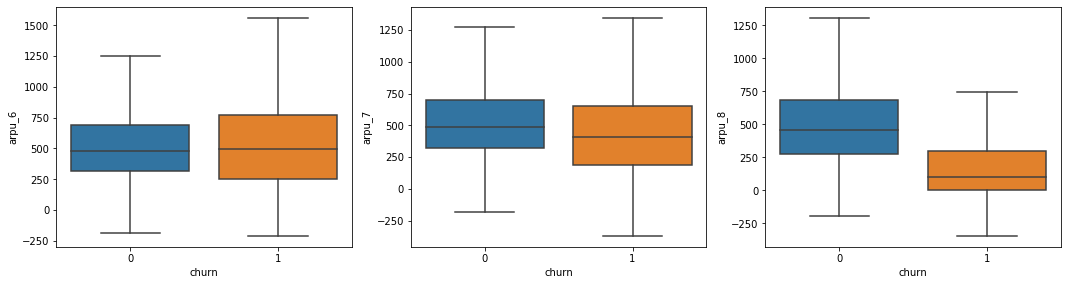

In [38]:
arpu = ['arpu_6', 'arpu_7', 'arpu_8']
plt.subplots(figsize=(18, 15))
for index, i in enumerate(arpu): 
    plt.subplot(3,3,index+1)
    sns.boxplot(x='churn', y=i, data=telecom, showfliers=False)
plt.show()

Following observations can be made from the relation of `arpu` features with churning:
    
1. The customers who churn are more likely to not generate revenue in the 3rd consecutive month and is evident from the plot that the mid 50 quantile shifts towards zero for the churn customers.
2. The non-churn customers tend to provide consistent revenue even in the 3rd month while the revenue from the churn customers starts to decrease.
3. The consistency of non-churn customers is same for all three months, this could mean that the `AON` (Age on Network) of these customers could be higher (i.e. the customers are old customers) as they've found a suitable plan for them and are choosing the same every month.<br/>

<br/><b>We can verify this by analysing `aon` now:</b>

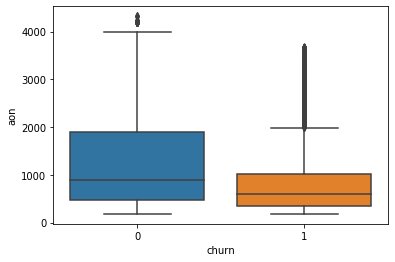

In [39]:
sns.boxplot(x='churn', y='aon', data=telecom)
plt.show()

In [40]:
telecom.groupby('churn')['aon'].describe()

count         mean         std    min    25%    50%      75%     max
churn                                                                        
0      26735.0  1253.849074  972.421139  180.0  475.0  896.0  1887.50  4321.0
1       3266.0   845.259339  731.856488  180.0  356.0  599.0  1007.75  3670.0

1. We can observe that the customers who have stayed longer with the network are more likely to stay (50-75 quantile of non-churn is above 75th of churn).<br/>
2. But this doesn't guarantee that customers who've stayed for long will never drop as evident from the outliers on the churn bar.
<br/><br/>

#### Data volume usage:

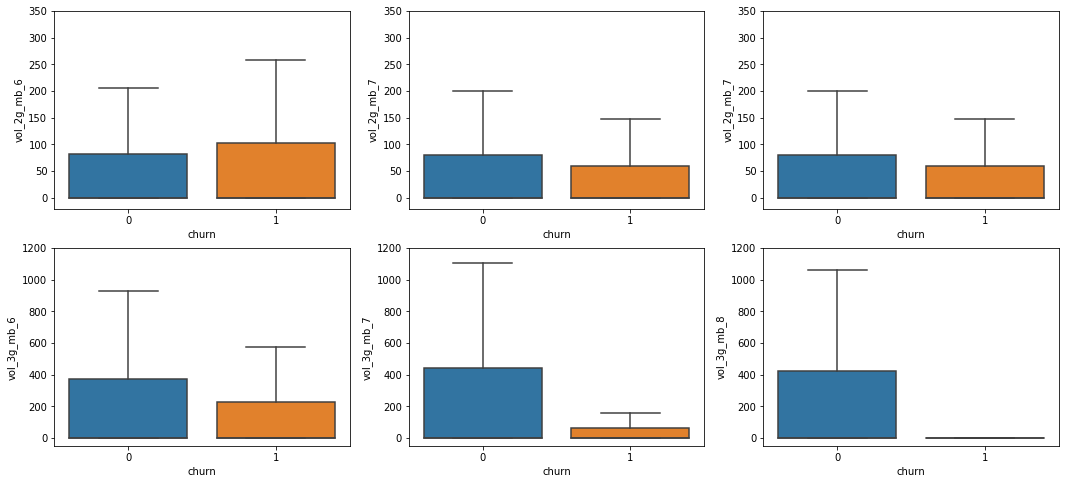

In [41]:
data = ['vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_7',
        'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8']
plt.subplots(figsize=(18, 8))
for index, i in enumerate(data): 
    plt.subplot(2,3,index+1)
    if index in [0,1,2]:
        plt.ylim(-20,350)
    else:
        plt.ylim(-50, 1200)
    sns.boxplot(x='churn', y=i, data=telecom, showfliers=False)
plt.show()

#### Onnet & Offnet usage

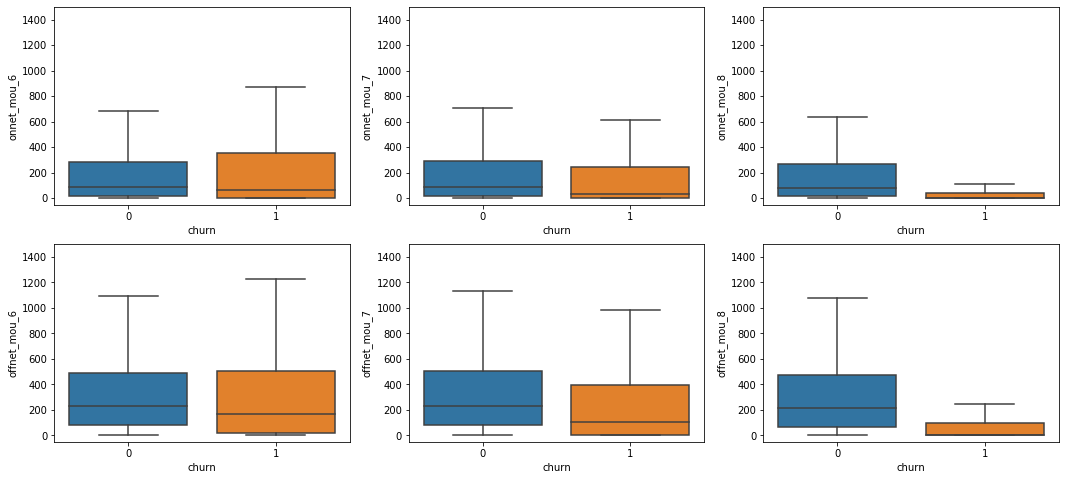

In [42]:
net = ['onnet_mou_6', 'onnet_mou_7','onnet_mou_8','offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
plt.subplots(figsize=(18, 8))
for index, i in enumerate(net): 
    plt.subplot(2,3,index+1)
    plt.ylim(-50, 1500)
    sns.boxplot(x='churn', y=i, data=telecom, showfliers=False)
plt.show()

We observe a drastic drop in `onnet` and `offnet` usage in the churning customers and is consistent for the customers that do not churn. Even in the good phase, the usage is seen to be reducing in the 2nd month for churn customers. <i>This usage can be a potential indicator for churning.</i><br/><br/>

#### Total OG/IC Usage

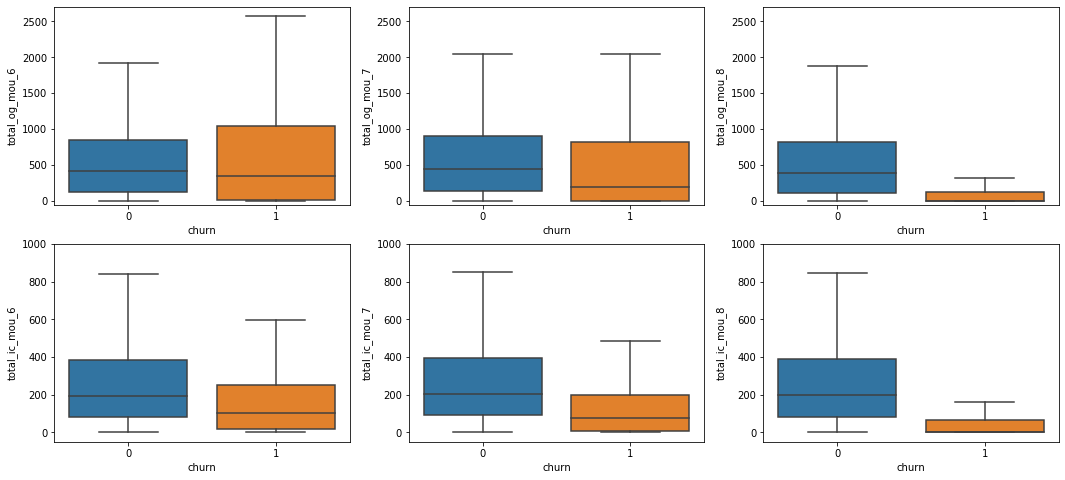

In [43]:
tot = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8',
       'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
plt.subplots(figsize=(18, 8))
for index, i in enumerate(tot): 
    plt.subplot(2,3,index+1)
    if index in [0,1,2]:
        plt.ylim(-50, 2700)
    else:
        plt.ylim(-50, 1000)
    sns.boxplot(x='churn', y=i, data=telecom, showfliers=False)
plt.show()

A similar trend is observed in `total_ic_mou` and `total_og_mou`.<br/>
While the decrease in usage is low from 6th to 7th month, the drop is huge in usage for churn customers from 7th to 8th month.

#### Number of recharges

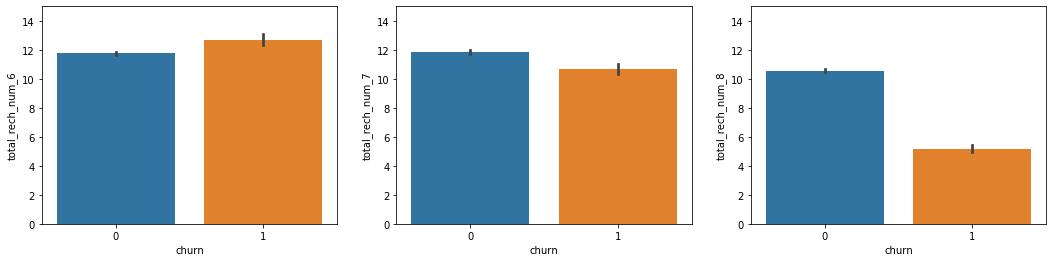

In [44]:
rech = ['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8']
plt.subplots(figsize=(18, 4))
for index, i in enumerate(rech):
    plt.subplot(1,3,index+1)
    plt.ylim(0,15)
    sns.barplot(x='churn', y=i, data=telecom)
plt.show()

#### Amount of Recharges

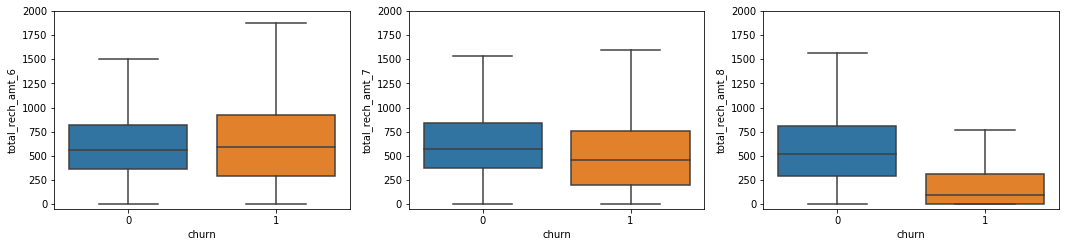

In [45]:
rech = ['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8']
plt.subplots(figsize=(18, 8))
for index, i in enumerate(rech): 
    plt.subplot(2,3,index+1)
    plt.ylim(-50, 2000)
    sns.boxplot(x='churn', y=i, data=telecom, showfliers=False)
plt.show()

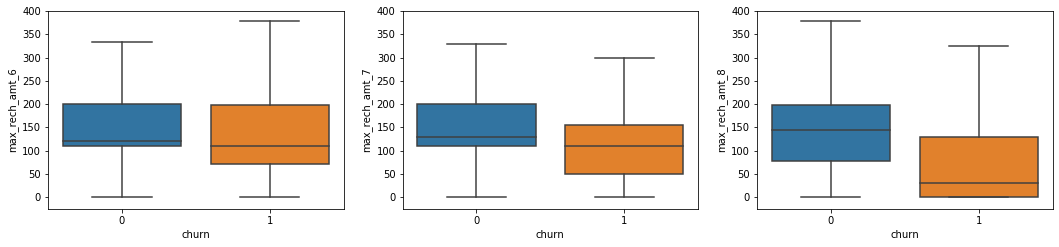

In [46]:
rech = ['max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8']
plt.subplots(figsize=(18, 8))
for index, i in enumerate(rech): 
    plt.subplot(2,3,index+1)
    plt.ylim(-25, 400)
    sns.boxplot(x='churn', y=i, data=telecom, showfliers=False)
plt.show()

While the median is droping for churn customers, there is no incremental pattern in `max_rech_amt`. We'll let these variables be as it is.

#### Other Services

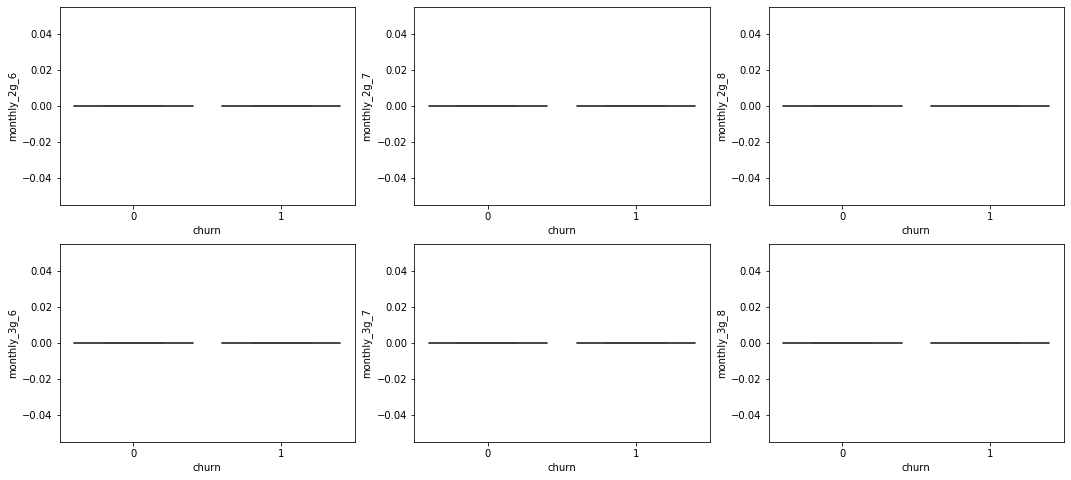

In [47]:
monthly = ['monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8',
           'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8']
plt.subplots(figsize=(18, 8))
for index, i in enumerate(monthly): 
    plt.subplot(2,3,index+1)
    sns.boxplot(x='churn', y=i, data=telecom, showfliers=False)
plt.show()

In [48]:
telecom[monthly].describe()

monthly_2g_6  monthly_2g_7  monthly_2g_8  monthly_3g_6  monthly_3g_7  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean       0.174494      0.183261      0.153628      0.217759      0.229026   
std        0.434953      0.450423      0.406486      0.613199      0.659125   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        4.000000      5.000000      5.000000     14.000000     16.000000   

       monthly_3g_8  
count  30001.000000  
mean       0.211026  
std        0.617549  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       16.000000

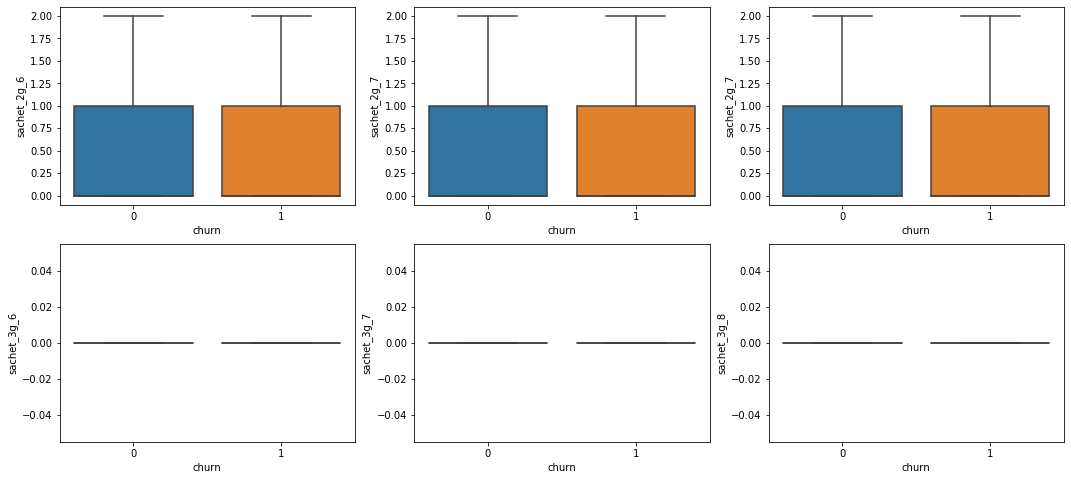

In [49]:
sachet = ['sachet_2g_6', 'sachet_2g_7', 'sachet_2g_7',
          'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']
plt.subplots(figsize=(18, 8))
for index, i in enumerate(sachet): 
    plt.subplot(2,3,index+1)
#     plt.ylim(-25, 400)
    sns.boxplot(x='churn', y=i, data=telecom, showfliers=False)
plt.show()

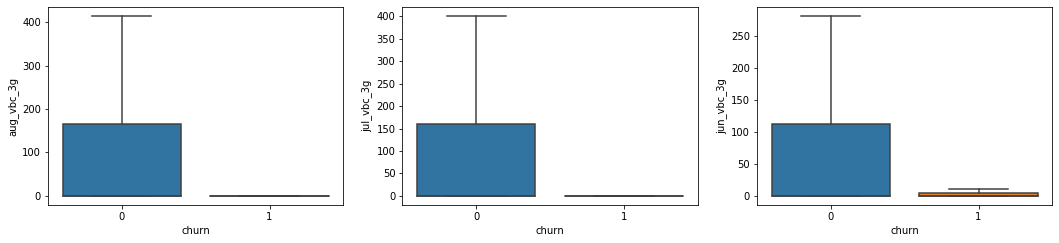

In [50]:
vbc = ['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g']
plt.subplots(figsize=(18, 8))
for index, i in enumerate(vbc): 
    plt.subplot(2,3,index+1)
#     plt.ylim(-25, 400)
    sns.boxplot(x='churn', y=i, data=telecom, showfliers=False)
plt.show()

There are no clear patterns arising from Other Services.

### Finding the Correlation 

In [51]:
telecom.shape

(30001, 135)

In [52]:
#Correlation Matrix
tel_corr = telecom.drop(['churn'], axis=1)

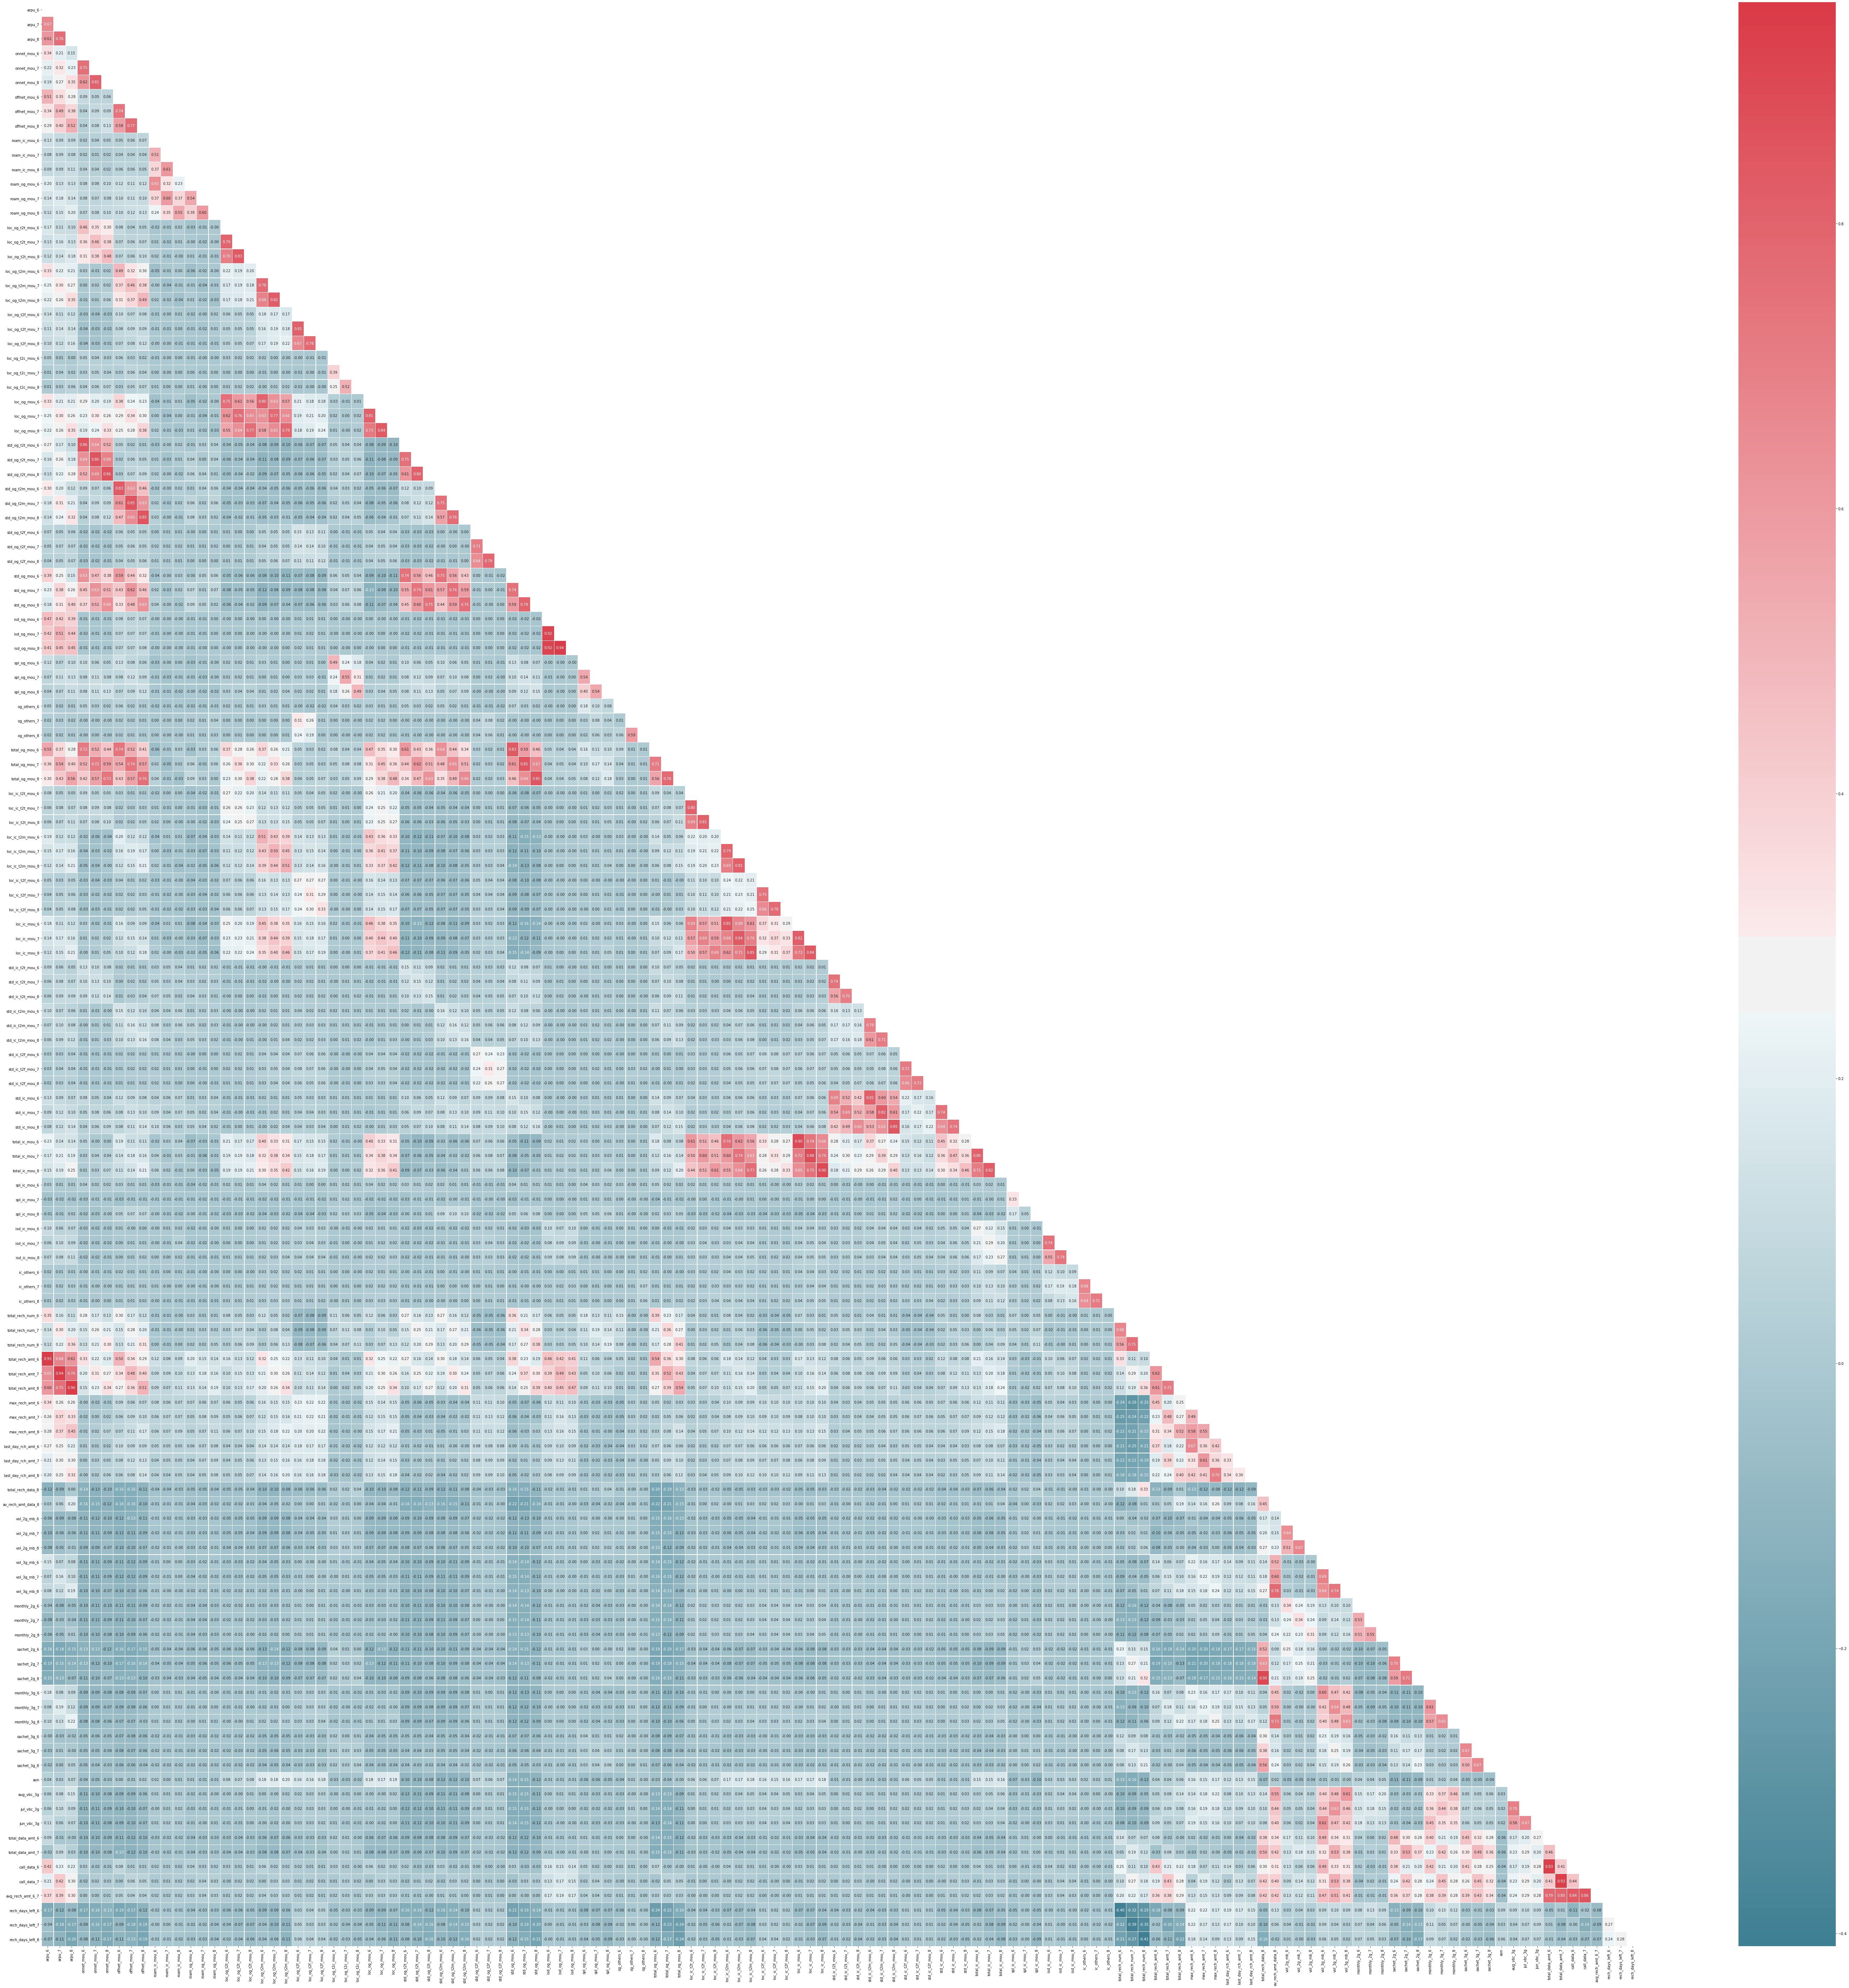

In [53]:
### Finding correlation among the columns

corr = tel_corr.corr()
fig, ax = plt.subplots(figsize=(100,100))
colormap = sns.diverging_palette(220,10, as_cmap = True)
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
colormap = sns.diverging_palette(220,10, as_cmap=True)
sns.heatmap(corr,cmap = colormap, linewidth=0.2, annot=True,fmt=".2f", mask=dropSelf)

plt.show()

In [54]:
#correlation matrix
corr_matrix = tel_corr.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.80
high_corr_cols = [column for column in upper.columns if any(upper[column] > 0.80)]

high_corr_cols

['onnet_mou_8',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_7',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'sachet_2g_8',
 'call_data_6',
 'call_data_7',
 'avg_rech_amt_6_7']

In [55]:
# Dropping the columns which are highly correlated

drop_corr_cols = ["onnet_mou_8", "loc_og_t2t_mou_8", "loc_og_t2m_mou_8", "loc_og_t2f_mou_7","loc_og_mou_6",
                 "loc_og_mou_7", "loc_og_mou_8","std_og_t2t_mou_6","std_og_t2t_mou_7","std_og_t2t_mou_8",
                 "std_og_t2m_mou_6","std_og_t2m_mou_7","std_og_t2m_mou_8","isd_og_mou_7","isd_og_mou_8",
                  "total_og_mou_6","total_og_mou_7","total_og_mou_8","loc_ic_t2t_mou_7","loc_ic_t2t_mou_8",
                 "loc_ic_t2m_mou_8","loc_ic_mou_6","loc_ic_mou_7","loc_ic_mou_8","std_ic_mou_6","std_ic_mou_7",
                 "total_ic_mou_6","std_ic_mou_8","total_ic_mou_7","total_ic_mou_8","total_rech_amt_6",
                  "total_rech_amt_7","total_rech_amt_8","sachet_2g_8","call_data_6","call_data_7","avg_rech_amt_6_7"]
telecom.drop(drop_corr_cols, axis=1, inplace=True)

In [56]:
telecom.shape

(30001, 98)

In [57]:
# lets create X & y dataset for model building
X = telecom.drop(['churn'], axis=1)
y = telecom['churn']

In [58]:
telecom = telecom.drop(['churn'], axis=1)

### Train & Test Split

In [59]:
# Splitting the dataset into test and train

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)

Dimension of X_train: (21000, 97)
Dimension of X_test: (9001, 97)


### Scaling

In [60]:
# Scaling the dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scale = scaler.fit_transform(X_train)

In [61]:
X_train_scale = pd.DataFrame(X_train_scale, columns = X.columns)
X_train_scale.head()

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  offnet_mou_6  \
0 -0.900760 -0.811381 -0.697469    -0.560799    -0.548096     -0.701973   
1 -0.685852 -0.651238 -0.881701    -0.556658    -0.557170     -0.746242   
2 -0.789438 -0.360778 -0.853846    -0.550543    -0.552476     -0.707966   
3  1.601696  2.808245  0.618529     2.056649     1.244442      1.674254   
4  0.433193 -0.032200 -0.574674     0.709156     0.329680      0.227116   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  ...  sachet_3g_8  \
0     -0.690416     -0.572309      -0.212948      -0.170386  ...    -0.187091   
1     -0.760976     -0.689284      -0.212948      -0.170386  ...    -0.187091   
2     -0.616298     -0.584198      -0.212948      -0.170386  ...    -0.187091   
3      2.675310      0.823602      -0.212948       1.356210  ...    -0.187091   
4      0.142283     -0.400864      -0.212948      -0.170386  ...    -0.187091   

        aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  total_data_amt_6  \
0  1.370598   -0.403872   -0.400289   -0.379289         -0.199003   
1  0.125577   -0.403872   -0.400289   -0.379289          0.210919   
2 -0.944723   -0.403872   -0.400289   -0.379289          1.007878   
3  0.581736   -0.308034    4.036563   -0.379289         -0.302661   
4 -0.784649   -0.403872   -0.400289   -0.379289         -0.302661   

   total_data_amt_7  rech_days_left_6  rech_days_left_7  rech_days_left_8  
0          0.064095          1.598011         -0.599154         -0.249381  
1          0.218995         -0.328995         -0.599154         -0.440501  
2          0.317377         -0.543107         -0.599154         -0.631621  
3         -0.187094         -0.114883         -0.161569         -0.822742  
4         -0.362926         -0.543107         -0.380362         -0.249381  

[5 rows x 97 columns]

### Balance data set by oversampling

In [62]:
print("Before applying SMOTE, counts of label '1': {}".format(sum(y_train==1)))
print("Before applying SMOTE, counts of label '0': {} \n".format(sum(y_train==0)))

Before applying SMOTE, counts of label '1': 2293
Before applying SMOTE, counts of label '0': 18707 



In [63]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2)
X_train_sm,y_train_sm = sm.fit_sample(X_train_scale,y_train)

In [64]:
print("After applying SMOTE, counts of label '1': {}".format(sum(y_train_sm==1)))
print("After applying SMOTE, counts of label '0': {} \n".format(sum(y_train_sm==0)))

After applying SMOTE, counts of label '1': 18707
After applying SMOTE, counts of label '0': 18707 



# Model 1 - Logistic Regression

In [65]:
# Logistic regression model
import statsmodels.api as sm

logm1 = sm.GLM(y_train_sm,(sm.add_constant(X_train_sm)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                37414
Model:                            GLM   Df Residuals:                    37316
Model Family:                Binomial   Df Model:                           97
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15337.
Date:                Mon, 06 Jul 2020   Deviance:                       30674.
Time:                        00:15:43   Pearson chi2:                 1.55e+12
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.7094      0.042    -40.902      0.000      -1.791      -1.627
arpu_6                 0.2711      0.044      6.130      0.000       0.184       0.358
arpu_7                 0.2206      0.044      4.990      0.000       0.134       0.307
arpu_8                -0.4609      0.054     -8.582      0.000      -0.566      -0.356
onnet_mou_6            0.5928      1.628      0.364      0.716      -2.598       3.783
onnet_mou_7           -0.4489      0.611     -0.735      0.463      -1.647       0.749
offnet_mou_6           0.4877      1.719      0.284      0.777      -2.881       3.856
offnet_mou_7           0.1327      0.639      0.208      0.836      -1.121       1.386
offnet_mou_8          -0.6893      0.054    -12.833      0.000      -0.795      -0.584
roam_ic_mou_6          0.0504      0.022      2.275      0.023       0.007       0.094
roam_ic_mou_7          0.0291      0.027      1.082      0.279      -0.024       0.082
roam_ic_mou_8          0.0163      0.021      0.772      0.440      -0.025       0.058
roam_og_mou_6         -0.2355      0.417     -0.565      0.572      -1.053       0.582
roam_og_mou_7          0.1125      0.120      0.941      0.347      -0.122       0.347
roam_og_mou_8          0.3265      0.025     13.094      0.000       0.278       0.375
loc_og_t2t_mou_6      -0.3040      0.798     -0.381      0.703      -1.867       1.259
loc_og_t2t_mou_7      -0.0591      0.312     -0.190      0.850      -0.670       0.552
loc_og_t2m_mou_6      -0.2678      0.895     -0.299      0.765      -2.021       1.486
loc_og_t2m_mou_7      -0.2505      0.310     -0.808      0.419      -0.859       0.357
loc_og_t2f_mou_6      -0.1685      0.082     -2.056      0.040      -0.329      -0.008
loc_og_t2f_mou_8      -0.3143      0.058     -5.379      0.000      -0.429      -0.200
loc_og_t2c_mou_6      -0.0626      0.023     -2.762      0.006      -0.107      -0.018
loc_og_t2c_mou_7      -0.0171      0.029     -0.591      0.555      -0.074       0.040
loc_og_t2c_mou_8       0.0132      0.034      0.391      0.696      -0.053       0.079
std_og_t2f_mou_6       0.0284      0.029      0.981      0.327      -0.028       0.085
std_og_t2f_mou_7      -0.0923      0.048     -1.910      0.056      -0.187       0.002
std_og_t2f_mou_8      -0.3121      0.070     -4.454      0.000      -0.449      -0.175
std_og_mou_6          -0.7038      2.169     -0.324      0.746      -4.955       3.548
std_og_mou_7           0.3627      0.810      0.448      0.654      -1.225       1.951
std_og_mou_8           0.1667      0.049      3.398      0.001       0.071       0.263
isd_og_mou_6           0.0465      0.090      0.517      0.605      -0.130       0.223
spl_og_mou_6           0.0005      0.061      0.009      0.993      -0.119       0.120
spl_og_mou_7          -0.0446      0.0

In [66]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [67]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 50)             # running RFE with 50 variables as output
rfe = rfe.fit(X_train_sm, y_train_sm)

In [68]:
rfe_features = list(telecom.columns[rfe.support_])
rfe_features

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_7',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2m_mou_7',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_8',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'spl_og_mou_8',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2f_mou_7',
 'loc_ic_t2f_mou_8',
 'std_ic_t2t_mou_6',
 'std_ic_t2t_mou_7',
 'std_ic_t2t_mou_8',
 'std_ic_t2m_mou_7',
 'std_ic_t2m_mou_8',
 'std_ic_t2f_mou_6',
 'std_ic_t2f_mou_8',
 'spl_ic_mou_6',
 'spl_ic_mou_8',
 'isd_ic_mou_8',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8',
 'total_rech_num_7',
 'total_rech_num_8',
 'max_rech_amt_7',
 'last_day_rch_amt_8',
 'vol_2g_mb_6',
 'vol_2g_mb_8',
 'vol_3g_mb_6',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'aon',
 'aug_vbc_3g',
 'jun_vbc_3g',
 'rech_days_left_7',
 'rech_days_left_8']

In [69]:
X_train_rfe = pd.DataFrame(data=X_train_sm).iloc[:, rfe.support_]
y_train_rfe = y_train_sm

In [70]:
X_test_rfe = pd.DataFrame(data=X_test).iloc[:, rfe.support_]
y_test_rfe = y_test

In [71]:
X_train1 = sm.add_constant(X_train_rfe)
logm2 = sm.GLM(y_train_sm,X_train1, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                37414
Model:                            GLM   Df Residuals:                    37363
Model Family:                Binomial   Df Model:                           50
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15416.
Date:                Mon, 06 Jul 2020   Deviance:                       30832.
Time:                        00:18:53   Pearson chi2:                 1.70e+12
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.7098      0.042    -40.604      0.000      -1.792      -1.627
arpu_6                 0.2608      0.024     11.092      0.000       0.215       0.307
arpu_7                 0.2212      0.036      6.196      0.000       0.151       0.291
arpu_8                -0.4992      0.046    -10.792      0.000      -0.590      -0.409
onnet_mou_7           -0.6397      0.059    -10.882      0.000      -0.755      -0.524
offnet_mou_7          -0.1792      0.076     -2.373      0.018      -0.327      -0.031
offnet_mou_8          -0.6870      0.053    -12.958      0.000      -0.791      -0.583
roam_og_mou_7          0.1608      0.022      7.469      0.000       0.119       0.203
roam_og_mou_8          0.3276      0.021     15.319      0.000       0.286       0.369
loc_og_t2m_mou_7      -0.1020      0.047     -2.169      0.030      -0.194      -0.010
loc_og_t2f_mou_6      -0.1188      0.041     -2.909      0.004      -0.199      -0.039
loc_og_t2f_mou_8      -0.3313      0.057     -5.844      0.000      -0.442      -0.220
std_og_t2f_mou_7      -0.0796      0.046     -1.742      0.081      -0.169       0.010
std_og_t2f_mou_8      -0.3048      0.069     -4.411      0.000      -0.440      -0.169
std_og_mou_7           0.6865      0.086      8.027      0.000       0.519       0.854
std_og_mou_8           0.1794      0.048      3.770      0.000       0.086       0.273
isd_og_mou_6           0.0983      0.025      4.006      0.000       0.050       0.146
spl_og_mou_8          -0.2896      0.034     -8.471      0.000      -0.357      -0.223
og_others_7            0.0812      0.036      2.260      0.024       0.011       0.152
og_others_8           -4.9126      1.824     -2.694      0.007      -8.487      -1.338
loc_ic_t2m_mou_7      -0.2055      0.025     -8.184      0.000      -0.255      -0.156
loc_ic_t2f_mou_7       0.2137      0.041      5.155      0.000       0.132       0.295
loc_ic_t2f_mou_8      -0.9473      0.073    -12.962      0.000      -1.091      -0.804
std_ic_t2t_mou_6       0.0897      0.030      2.989      0.003       0.031       0.148
std_ic_t2t_mou_7       0.1652      0.040      4.149      0.000       0.087       0.243
std_ic_t2t_mou_8      -0.6174      0.065     -9.429      0.000      -0.746      -0.489
std_ic_t2m_mou_7       0.0892      0.034      2.602      0.009       0.022       0.156
std_ic_t2m_mou_8      -0.3830      0.054     -7.063      0.000      -0.489      -0.277
std_ic_t2f_mou_6       0.0770      0.025      3.023      0.002       0.027       0.127
std_ic_t2f_mou_8      -0.4008      0.076     -5.276      0.000      -0.550      -0.252
spl_ic_mou_6          -0.1020      0.024     -4.311      0.000      -0.148      -0.056
spl_ic_mou_8          -0.3554      0.026    -13.605      0.000      -0.407      -0.304
isd_ic_mou_8          -0.0899      0.0

In [72]:
y_train_pred = res.predict(X_train1)
y_train_pred[:10]

0    0.162903
1    0.659120
2    0.296867
3    0.510304
4    0.427517
5    0.641092
6    0.000993
7    0.106173
8    0.014651
9    0.515007
dtype: float64

In [73]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.16290255, 0.65912035, 0.29686691, 0.51030355, 0.42751656,
       0.64109171, 0.00099317, 0.10617283, 0.01465117, 0.51500746])

In [74]:
y_train_pred_final = pd.DataFrame({'Churn':y_train_sm.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train_sm.index
y_train_pred_final.head()

Churn  Churn_Prob  CustID
0      0    0.162903       0
1      0    0.659120       1
2      0    0.296867       2
3      0    0.510304       3
4      0    0.427517       4

#### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [75]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

Churn  Churn_Prob  CustID  predicted
0      0    0.162903       0          0
1      0    0.659120       1          1
2      0    0.296867       2          0
3      0    0.510304       3          1
4      0    0.427517       4          0

In [76]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

[[15195  3512]
 [ 2727 15980]]


In [77]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.8332442401240178


#### Let's remove the varibales with high p-value

In [78]:
X_train_rfe = X_train_rfe.drop(['offnet_mou_7'], 1)
X_train_rfe.head()

arpu_6    arpu_7    arpu_8  onnet_mou_7  offnet_mou_8  roam_og_mou_7  \
0 -0.900760 -0.811381 -0.697469    -0.548096     -0.572309      -0.213417   
1 -0.685852 -0.651238 -0.881701    -0.557170     -0.689284      -0.213417   
2 -0.789438 -0.360778 -0.853846    -0.552476     -0.584198      -0.213417   
3  1.601696  2.808245  0.618529     1.244442      0.823602       7.533905   
4  0.433193 -0.032200 -0.574674     0.329680     -0.400864      -0.213417   

   roam_og_mou_8  loc_og_t2m_mou_7  loc_og_t2f_mou_6  loc_og_t2f_mou_8  ...  \
0      -0.194035         -0.556004         -0.202233         -0.248126  ...   
1      -0.194035         -0.672105         -0.222497         -0.293921  ...   
2      -0.194035         -0.376645         -0.302585         -0.293921  ...   
3      -0.194035         -0.458258          0.072770         -0.089604  ...   
4      -0.194035          0.977804         -0.302585         -0.293921  ...   

   vol_2g_mb_8  vol_3g_mb_6  monthly_2g_6  monthly_2g_7  monthly_2g_8  \
0     0.243782    -0.370856      1.878701      1.815720      2.084470   
1     0.616799    -0.354346     -0.405103     -0.406703     -0.378056   
2     1.022808    -0.370856     -0.405103      4.038143     -0.378056   
3    -0.337229    -0.370856     -0.405103     -0.406703     -0.378056   
4    -0.337390    -0.370856     -0.405103     -0.406703     -0.378056   

        aon  aug_vbc_3g  jun_vbc_3g  rech_days_left_7  rech_days_left_8  
0  1.370598   -0.403872   -0.379289         -0.599154         -0.249381  
1  0.125577   -0.403872   -0.379289         -0.599154         -0.440501  
2 -0.944723   -0.403872   -0.379289         -0.599154         -0.631621  
3  0.581736   -0.308034   -0.379289         -0.161569         -0.822742  
4 -0.784649   -0.403872   -0.379289         -0.380362         -0.249381  

[5 rows x 49 columns]

In [79]:
# Let's re-run the model using the selected variables
X_train1 = sm.add_constant(X_train_rfe)
logm3 = sm.GLM(y_train_sm,X_train1, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                37414
Model:                            GLM   Df Residuals:                    37364
Model Family:                Binomial   Df Model:                           49
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15419.
Date:                Mon, 06 Jul 2020   Deviance:                       30838.
Time:                        00:19:56   Pearson chi2:                 1.65e+12
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.7083      0.042    -40.429      0.000      -1.791      -1.625
arpu_6                 0.2591      0.023     11.027      0.000       0.213       0.305
arpu_7                 0.2038      0.035      5.861      0.000       0.136       0.272
arpu_8                -0.4920      0.046    -10.661      0.000      -0.582      -0.402
onnet_mou_7           -0.5256      0.032    -16.274      0.000      -0.589      -0.462
offnet_mou_8          -0.7451      0.047    -15.767      0.000      -0.838      -0.653
roam_og_mou_7          0.1360      0.019      7.246      0.000       0.099       0.173
roam_og_mou_8          0.3322      0.021     15.593      0.000       0.290       0.374
loc_og_t2m_mou_7      -0.1819      0.033     -5.579      0.000      -0.246      -0.118
loc_og_t2f_mou_6      -0.1229      0.041     -3.011      0.003      -0.203      -0.043
loc_og_t2f_mou_8      -0.3289      0.057     -5.802      0.000      -0.440      -0.218
std_og_t2f_mou_7      -0.0809      0.046     -1.768      0.077      -0.171       0.009
std_og_t2f_mou_8      -0.3025      0.069     -4.376      0.000      -0.438      -0.167
std_og_mou_7           0.5105      0.041     12.383      0.000       0.430       0.591
std_og_mou_8           0.2044      0.046      4.434      0.000       0.114       0.295
isd_og_mou_6           0.0963      0.024      3.938      0.000       0.048       0.144
spl_og_mou_8          -0.2897      0.034     -8.482      0.000      -0.357      -0.223
og_others_7            0.0811      0.036      2.258      0.024       0.011       0.152
og_others_8           -4.9152      1.835     -2.679      0.007      -8.511      -1.320
loc_ic_t2m_mou_7      -0.2052      0.025     -8.160      0.000      -0.255      -0.156
loc_ic_t2f_mou_7       0.2092      0.041      5.056      0.000       0.128       0.290
loc_ic_t2f_mou_8      -0.9428      0.073    -12.913      0.000      -1.086      -0.800
std_ic_t2t_mou_6       0.0903      0.030      3.020      0.003       0.032       0.149
std_ic_t2t_mou_7       0.1699      0.039      4.330      0.000       0.093       0.247
std_ic_t2t_mou_8      -0.6201      0.065     -9.491      0.000      -0.748      -0.492
std_ic_t2m_mou_7       0.0834      0.034      2.447      0.014       0.017       0.150
std_ic_t2m_mou_8      -0.3789      0.054     -7.017      0.000      -0.485      -0.273
std_ic_t2f_mou_6       0.0766      0.025      3.006      0.003       0.027       0.127
std_ic_t2f_mou_8      -0.4006      0.076     -5.270      0.000      -0.550      -0.252
spl_ic_mou_6          -0.1024      0.024     -4.328      0.000      -0.149      -0.056
spl_ic_mou_8          -0.3560      0.026    -13.627      0.000      -0.407      -0.305
isd_ic_mou_8          -0.0900      0.031     -2.935      0.003      -0.150      -0.030
ic_others_6           -0.1807      0.0

### Checking VIF

In [80]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [81]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
2               arpu_8  5.43
13        std_og_mou_8  5.06
4         offnet_mou_8  4.46
12        std_og_mou_7  4.28
35    total_rech_num_8  3.53
1               arpu_7  3.43
32         ic_others_7  3.34
22    std_ic_t2t_mou_7  3.06
34    total_rech_num_7  2.92
33         ic_others_8  2.73
31         ic_others_6  2.56
20    loc_ic_t2f_mou_8  2.54
3          onnet_mou_7  2.47
11    std_og_t2f_mou_8  2.46
19    loc_ic_t2f_mou_7  2.44
10    std_og_t2f_mou_7  2.42
7     loc_og_t2m_mou_7  2.35
9     loc_og_t2f_mou_8  2.24
21    std_ic_t2t_mou_6  2.23
8     loc_og_t2f_mou_6  2.11
23    std_ic_t2t_mou_8  2.04
0               arpu_6  1.97
46          jun_vbc_3g  1.95
25    std_ic_t2m_mou_8  1.92
24    std_ic_t2m_mou_7  1.88
6        roam_og_mou_8  1.88
5        roam_og_mou_7  1.86
40         vol_3g_mb_6  1.80
43        monthly_2g_8  1.77
41        monthly_2g_6  1.70
42        monthly_2g_7  1.69
18    loc_ic_t2m_mou_7  1.60
36      max_rech_amt_7  1.57
27    std_ic_t2f_mou_8  1.57
45          aug_vbc_3g  1.56
38         vol_2g_mb_6  1.54
37  last_day_rch_amt_8  1.50
26    std_ic_t2f_mou_6  1.48
39         vol_2g_mb_8  1.48
14        isd_og_mou_6  1.46
47    rech_days_left_7  1.34
48    rech_days_left_8  1.27
44                 aon  1.20
15        spl_og_mou_8  1.09
29        spl_ic_mou_8  1.09
30        isd_ic_mou_8  1.08
17         og_others_8  1.06
28        spl_ic_mou_6  1.06
16         og_others_7  1.05

In [82]:
X_train_rfe = X_train_rfe.drop(['arpu_8','std_og_mou_8'], 1)
X_train_rfe.head()

arpu_6    arpu_7  onnet_mou_7  offnet_mou_8  roam_og_mou_7  \
0 -0.900760 -0.811381    -0.548096     -0.572309      -0.213417   
1 -0.685852 -0.651238    -0.557170     -0.689284      -0.213417   
2 -0.789438 -0.360778    -0.552476     -0.584198      -0.213417   
3  1.601696  2.808245     1.244442      0.823602       7.533905   
4  0.433193 -0.032200     0.329680     -0.400864      -0.213417   

   roam_og_mou_8  loc_og_t2m_mou_7  loc_og_t2f_mou_6  loc_og_t2f_mou_8  \
0      -0.194035         -0.556004         -0.202233         -0.248126   
1      -0.194035         -0.672105         -0.222497         -0.293921   
2      -0.194035         -0.376645         -0.302585         -0.293921   
3      -0.194035         -0.458258          0.072770         -0.089604   
4      -0.194035          0.977804         -0.302585         -0.293921   

   std_og_t2f_mou_7  ...  vol_2g_mb_8  vol_3g_mb_6  monthly_2g_6  \
0         -0.142696  ...     0.243782    -0.370856      1.878701   
1         -0.142696  ...     0.616799    -0.354346     -0.405103   
2         -0.142696  ...     1.022808    -0.370856     -0.405103   
3         -0.142696  ...    -0.337229    -0.370856     -0.405103   
4         -0.142696  ...    -0.337390    -0.370856     -0.405103   

   monthly_2g_7  monthly_2g_8       aon  aug_vbc_3g  jun_vbc_3g  \
0      1.815720      2.084470  1.370598   -0.403872   -0.379289   
1     -0.406703     -0.378056  0.125577   -0.403872   -0.379289   
2      4.038143     -0.378056 -0.944723   -0.403872   -0.379289   
3     -0.406703     -0.378056  0.581736   -0.308034   -0.379289   
4     -0.406703     -0.378056 -0.784649   -0.403872   -0.379289   

   rech_days_left_7  rech_days_left_8  
0         -0.599154         -0.249381  
1         -0.599154         -0.440501  
2         -0.599154         -0.631621  
3         -0.161569         -0.822742  
4         -0.380362         -0.249381  

[5 rows x 47 columns]

In [83]:
# Let's re-run the model using the selected variables
X_train1 = sm.add_constant(X_train_rfe)
logm4 = sm.GLM(y_train_sm,X_train1, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                37414
Model:                            GLM   Df Residuals:                    37366
Model Family:                Binomial   Df Model:                           47
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15480.
Date:                Mon, 06 Jul 2020   Deviance:                       30961.
Time:                        00:36:13   Pearson chi2:                 1.06e+11
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.7107      0.042    -40.694      0.000      -1.793      -1.628
arpu_6                 0.2158      0.023      9.561      0.000       0.172       0.260
arpu_7                 0.0477      0.028      1.711      0.087      -0.007       0.102
onnet_mou_7           -0.5653      0.030    -18.839      0.000      -0.624      -0.506
offnet_mou_8          -0.8369      0.040    -20.809      0.000      -0.916      -0.758
roam_og_mou_7          0.1534      0.018      8.433      0.000       0.118       0.189
roam_og_mou_8          0.2611      0.019     13.797      0.000       0.224       0.298
loc_og_t2m_mou_7      -0.1734      0.032     -5.481      0.000      -0.235      -0.111
loc_og_t2f_mou_6      -0.1204      0.041     -2.954      0.003      -0.200      -0.041
loc_og_t2f_mou_8      -0.3916      0.058     -6.779      0.000      -0.505      -0.278
std_og_t2f_mou_7      -0.0749      0.046     -1.622      0.105      -0.165       0.016
std_og_t2f_mou_8      -0.3153      0.069     -4.553      0.000      -0.451      -0.180
std_og_mou_7           0.6545      0.038     17.309      0.000       0.580       0.729
isd_og_mou_6           0.0382      0.022      1.711      0.087      -0.006       0.082
spl_og_mou_8          -0.2932      0.034     -8.562      0.000      -0.360      -0.226
og_others_7            0.0828      0.036      2.312      0.021       0.013       0.153
og_others_8           -4.8167      1.819     -2.648      0.008      -8.382      -1.251
loc_ic_t2m_mou_7      -0.2038      0.025     -8.170      0.000      -0.253      -0.155
loc_ic_t2f_mou_7       0.2190      0.041      5.372      0.000       0.139       0.299
loc_ic_t2f_mou_8      -0.9751      0.073    -13.300      0.000      -1.119      -0.831
std_ic_t2t_mou_6       0.0995      0.030      3.333      0.001       0.041       0.158
std_ic_t2t_mou_7       0.1798      0.039      4.607      0.000       0.103       0.256
std_ic_t2t_mou_8      -0.6539      0.066     -9.946      0.000      -0.783      -0.525
std_ic_t2m_mou_7       0.0874      0.034      2.534      0.011       0.020       0.155
std_ic_t2m_mou_8      -0.3986      0.055     -7.264      0.000      -0.506      -0.291
std_ic_t2f_mou_6       0.0792      0.025      3.118      0.002       0.029       0.129
std_ic_t2f_mou_8      -0.4230      0.077     -5.528      0.000      -0.573      -0.273
spl_ic_mou_6          -0.1050      0.024     -4.451      0.000      -0.151      -0.059
spl_ic_mou_8          -0.3553      0.026    -13.549      0.000      -0.407      -0.304
isd_ic_mou_8          -0.1087      0.032     -3.375      0.001      -0.172      -0.046
ic_others_6           -0.1672      0.066     -2.546      0.011      -0.296      -0.038
ic_others_7            0.1054      0.039      2.728      0.006       0.030       0.181
ic_others_8           -0.1961      0.0

In [84]:
X_train_rfe = X_train_rfe.drop(['isd_og_mou_6','arpu_7'], 1)
X_train_rfe.head()

arpu_6  onnet_mou_7  offnet_mou_8  roam_og_mou_7  roam_og_mou_8  \
0 -0.900760    -0.548096     -0.572309      -0.213417      -0.194035   
1 -0.685852    -0.557170     -0.689284      -0.213417      -0.194035   
2 -0.789438    -0.552476     -0.584198      -0.213417      -0.194035   
3  1.601696     1.244442      0.823602       7.533905      -0.194035   
4  0.433193     0.329680     -0.400864      -0.213417      -0.194035   

   loc_og_t2m_mou_7  loc_og_t2f_mou_6  loc_og_t2f_mou_8  std_og_t2f_mou_7  \
0         -0.556004         -0.202233         -0.248126         -0.142696   
1         -0.672105         -0.222497         -0.293921         -0.142696   
2         -0.376645         -0.302585         -0.293921         -0.142696   
3         -0.458258          0.072770         -0.089604         -0.142696   
4          0.977804         -0.302585         -0.293921         -0.142696   

   std_og_t2f_mou_8  ...  vol_2g_mb_8  vol_3g_mb_6  monthly_2g_6  \
0         -0.144382  ...     0.243782    -0.370856      1.878701   
1         -0.144382  ...     0.616799    -0.354346     -0.405103   
2         -0.144382  ...     1.022808    -0.370856     -0.405103   
3         -0.144382  ...    -0.337229    -0.370856     -0.405103   
4         -0.144382  ...    -0.337390    -0.370856     -0.405103   

   monthly_2g_7  monthly_2g_8       aon  aug_vbc_3g  jun_vbc_3g  \
0      1.815720      2.084470  1.370598   -0.403872   -0.379289   
1     -0.406703     -0.378056  0.125577   -0.403872   -0.379289   
2      4.038143     -0.378056 -0.944723   -0.403872   -0.379289   
3     -0.406703     -0.378056  0.581736   -0.308034   -0.379289   
4     -0.406703     -0.378056 -0.784649   -0.403872   -0.379289   

   rech_days_left_7  rech_days_left_8  
0         -0.599154         -0.249381  
1         -0.599154         -0.440501  
2         -0.599154         -0.631621  
3         -0.161569         -0.822742  
4         -0.380362         -0.249381  

[5 rows x 45 columns]

In [85]:
# Let's re-run the model using the selected variables
X_train1 = sm.add_constant(X_train_rfe)
logm5 = sm.GLM(y_train_sm,X_train1, family = sm.families.Binomial())
res = logm5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                37414
Model:                            GLM   Df Residuals:                    37368
Model Family:                Binomial   Df Model:                           45
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15484.
Date:                Mon, 06 Jul 2020   Deviance:                       30969.
Time:                        00:36:49   Pearson chi2:                 1.07e+11
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.7085      0.042    -40.642      0.000      -1.791      -1.626
arpu_6                 0.2442      0.020     12.210      0.000       0.205       0.283
onnet_mou_7           -0.5631      0.030    -18.803      0.000      -0.622      -0.504
offnet_mou_8          -0.8325      0.040    -20.738      0.000      -0.911      -0.754
roam_og_mou_7          0.1565      0.018      8.873      0.000       0.122       0.191
roam_og_mou_8          0.2598      0.019     13.739      0.000       0.223       0.297
loc_og_t2m_mou_7      -0.1691      0.031     -5.519      0.000      -0.229      -0.109
loc_og_t2f_mou_6      -0.1252      0.041     -3.079      0.002      -0.205      -0.046
loc_og_t2f_mou_8      -0.3864      0.058     -6.710      0.000      -0.499      -0.274
std_og_t2f_mou_7      -0.0716      0.046     -1.552      0.121      -0.162       0.019
std_og_t2f_mou_8      -0.3148      0.069     -4.562      0.000      -0.450      -0.180
std_og_mou_7           0.6583      0.036     18.035      0.000       0.587       0.730
spl_og_mou_8          -0.2968      0.034     -8.660      0.000      -0.364      -0.230
og_others_7            0.0819      0.036      2.291      0.022       0.012       0.152
og_others_8           -4.8180      1.821     -2.646      0.008      -8.387      -1.249
loc_ic_t2m_mou_7      -0.2031      0.025     -8.164      0.000      -0.252      -0.154
loc_ic_t2f_mou_7       0.2203      0.041      5.396      0.000       0.140       0.300
loc_ic_t2f_mou_8      -0.9800      0.073    -13.355      0.000      -1.124      -0.836
std_ic_t2t_mou_6       0.0959      0.030      3.204      0.001       0.037       0.155
std_ic_t2t_mou_7       0.1827      0.039      4.700      0.000       0.106       0.259
std_ic_t2t_mou_8      -0.6527      0.066     -9.929      0.000      -0.781      -0.524
std_ic_t2m_mou_7       0.0883      0.035      2.558      0.011       0.021       0.156
std_ic_t2m_mou_8      -0.4012      0.055     -7.293      0.000      -0.509      -0.293
std_ic_t2f_mou_6       0.0791      0.025      3.122      0.002       0.029       0.129
std_ic_t2f_mou_8      -0.4223      0.076     -5.522      0.000      -0.572      -0.272
spl_ic_mou_6          -0.1069      0.024     -4.531      0.000      -0.153      -0.061
spl_ic_mou_8          -0.3556      0.026    -13.562      0.000      -0.407      -0.304
isd_ic_mou_8          -0.0922      0.030     -3.063      0.002      -0.151      -0.033
ic_others_6           -0.1727      0.066     -2.609      0.009      -0.302      -0.043
ic_others_7            0.1075      0.039      2.762      0.006       0.031       0.184
ic_others_8           -0.1997      0.068     -2.926      0.003      -0.333      -0.066
total_rech_num_7       0.4563      0.027     16.794      0.000       0.403       0.510
total_rech_num_8      -1.1011      0.0

In [86]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
28         ic_others_7  3.33
10        std_og_mou_7  3.17
18    std_ic_t2t_mou_7  3.06
31    total_rech_num_8  2.76
29         ic_others_8  2.73
27         ic_others_6  2.56
16    loc_ic_t2f_mou_8  2.54
2         offnet_mou_8  2.53
30    total_rech_num_7  2.51
9     std_og_t2f_mou_8  2.46
15    loc_ic_t2f_mou_7  2.44
8     std_og_t2f_mou_7  2.41
7     loc_og_t2f_mou_8  2.22
17    std_ic_t2t_mou_6  2.22
1          onnet_mou_7  2.11
6     loc_og_t2f_mou_6  2.11
19    std_ic_t2t_mou_8  2.01
5     loc_og_t2m_mou_7  2.01
42          jun_vbc_3g  1.95
21    std_ic_t2m_mou_8  1.91
20    std_ic_t2m_mou_7  1.88
36         vol_3g_mb_6  1.76
39        monthly_2g_8  1.75
3        roam_og_mou_7  1.72
37        monthly_2g_6  1.70
38        monthly_2g_7  1.67
4        roam_og_mou_8  1.66
14    loc_ic_t2m_mou_7  1.60
23    std_ic_t2f_mou_8  1.57
34         vol_2g_mb_6  1.53
41          aug_vbc_3g  1.51
22    std_ic_t2f_mou_6  1.48
35         vol_2g_mb_8  1.48
0               arpu_6  1.34
33  last_day_rch_amt_8  1.33
43    rech_days_left_7  1.32
32      max_rech_amt_7  1.30
44    rech_days_left_8  1.26
40                 aon  1.20
25        spl_ic_mou_8  1.09
11        spl_og_mou_8  1.09
26        isd_ic_mou_8  1.06
24        spl_ic_mou_6  1.06
13         og_others_8  1.06
12         og_others_7  1.05

In [87]:
y_train_pred = res.predict(X_train1).values.reshape(-1)

In [88]:
y_train_pred[:10]

array([0.16193115, 0.65252995, 0.28337218, 0.44158416, 0.42033294,
       0.64302886, 0.00102857, 0.082889  , 0.01042478, 0.50449487])

In [89]:
y_train_pred_final['Churn_Prob'] = y_train_pred

In [90]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

Churn  Churn_Prob  CustID  predicted
0      0    0.161931       0          0
1      0    0.652530       1          1
2      0    0.283372       2          0
3      0    0.441584       3          0
4      0    0.420333       4          0

In [91]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.8339391671566794


In [92]:
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
confusion

array([[15179,  3528],
       [ 2685, 16022]], dtype=int64)

In [93]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [94]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.856470839792591

In [95]:
# Let us calculate specificity
TN / float(TN+FP)

0.8114074945207677

### ROC Curve

In [96]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [97]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )

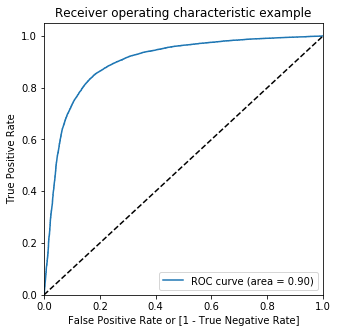

In [98]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

### Finding Optimal Cut-off

In [99]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Churn  Churn_Prob  CustID  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
0      0    0.161931       0          0    1    1    0    0    0    0    0   
1      0    0.652530       1          1    1    1    1    1    1    1    1   
2      0    0.283372       2          0    1    1    1    0    0    0    0   
3      0    0.441584       3          0    1    1    1    1    1    0    0   
4      0    0.420333       4          0    1    1    1    1    1    0    0   

   0.7  0.8  0.9  
0    0    0    0  
1    0    0    0  
2    0    0    0  
3    0    0    0  
4    0    0    0

In [100]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.683434  0.976052  0.390816
0.2   0.2  0.751056  0.957556  0.544556
0.3   0.3  0.793099  0.933287  0.652911
0.4   0.4  0.819239  0.900037  0.738440
0.5   0.5  0.833939  0.856471  0.811407
0.6   0.6  0.829609  0.793072  0.866146
0.7   0.7  0.808467  0.704175  0.912760
0.8   0.8  0.751777  0.554605  0.948950
0.9   0.9  0.612338  0.244561  0.980114


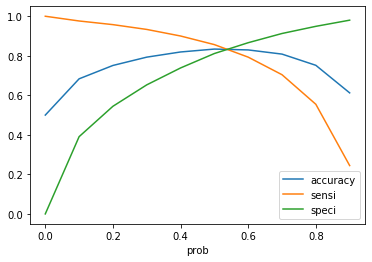

In [101]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### From the curve above, 0.55 is the optimum point to take it as a cutoff probability.¶

In [102]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.55 else 0)

y_train_pred_final.head()

Churn  Churn_Prob  CustID  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
0      0    0.161931       0          0    1    1    0    0    0    0    0   
1      0    0.652530       1          1    1    1    1    1    1    1    1   
2      0    0.283372       2          0    1    1    1    0    0    0    0   
3      0    0.441584       3          0    1    1    1    1    1    0    0   
4      0    0.420333       4          0    1    1    1    1    1    0    0   

   0.7  0.8  0.9  final_predicted  
0    0    0    0                0  
1    0    0    0                1  
2    0    0    0                0  
3    0    0    0                0  
4    0    0    0                0

In [103]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted)

0.8342064467846261

In [104]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.final_predicted )
confusion2

array([[15708,  2999],
       [ 3204, 15503]], dtype=int64)

In [105]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [106]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8287272144117176

In [107]:
# Let us calculate specificity
TN / float(TN+FP)

0.8396856791575346

In [108]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.16031432084246539


In [109]:
# Positive predictive value 
print (TP / float(TP+FP))

0.8379094151983569


In [110]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8305837563451777


### Making preditions on test data

In [111]:
X_test_scale = scaler.transform(X_test)

In [112]:
cols = X.columns

In [113]:
X_test_scale = pd.DataFrame(X_test_scale, columns = cols)
X_test_scale.head()

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  offnet_mou_6  \
0 -0.837465 -1.129487 -1.090390    -0.228230    -0.557170     -0.715682   
1 -0.747327 -0.165114 -0.411571    -0.473353    -0.467422     -0.582938   
2  0.389561  0.121176 -0.010076    -0.512165     0.090508     -0.588007   
3 -0.513312 -0.680012 -0.571438    -0.241782    -0.540700     -0.746980   
4 -0.537091  1.386088  1.133915    -0.473396    -0.367240      0.674688   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  ...  sachet_3g_8  \
0     -0.749859     -0.689284      -0.212948      -0.170386  ...    -0.187091   
1     -0.299549     -0.474768      -0.212948      -0.170386  ...    -0.187091   
2     -0.268898     -0.152577      -0.212948      -0.170386  ...    -0.187091   
3     -0.686977     -0.672908      -0.212948      -0.170386  ...    -0.187091   
4      3.928387      3.176604      -0.212948      -0.132466  ...    -0.187091   

        aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  total_data_amt_6  \
0 -1.019005   -0.403872   -0.400289   -0.379289         -0.291219   
1  0.116161   -0.047504    0.805740   -0.379289          0.106588   
2  1.295269    3.449245    1.570352    1.466351          0.375831   
3 -0.970879    0.847624    0.678671    0.512748          0.145628   
4 -0.688395   -0.403872   -0.400289   -0.379289         -0.302661   

   total_data_amt_7  rech_days_left_6  rech_days_left_7  rech_days_left_8  
0          0.073166          1.169788         -0.817947          4.146383  
1         -0.261753         -0.757219         -0.817947          0.132859  
2         -0.187094          1.383899         -0.161569         -0.058261  
3          0.359940          1.598011          1.588773          1.661821  
4         -0.362926         -0.328995          0.057224         -0.440501  

[5 rows x 97 columns]

In [114]:
cols = X_train1.columns[1:]
cols

Index(['arpu_6', 'onnet_mou_7', 'offnet_mou_8', 'roam_og_mou_7',
       'roam_og_mou_8', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_8', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8',
       'std_og_mou_7', 'spl_og_mou_8', 'og_others_7', 'og_others_8',
       'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8',
       'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_6',
       'std_ic_t2f_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_8', 'isd_ic_mou_8',
       'ic_others_6', 'ic_others_7', 'ic_others_8', 'total_rech_num_7',
       'total_rech_num_8', 'max_rech_amt_7', 'last_day_rch_amt_8',
       'vol_2g_mb_6', 'vol_2g_mb_8', 'vol_3g_mb_6', 'monthly_2g_6',
       'monthly_2g_7', 'monthly_2g_8', 'aon', 'aug_vbc_3g', 'jun_vbc_3g',
       'rech_days_left_7', 'rech_days_left_8'],
      dtype='object')

In [115]:
X_test_scale = X_test_scale[cols]
X_test_scale.shape

(9001, 45)

In [116]:
X_test1 = sm.add_constant(X_test_scale)

In [117]:
y_test_pred = res.predict(X_test1)

In [118]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [119]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [120]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

In [121]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [122]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final.head()

churn  CustID         0
0      0   35865  0.950820
1      0   41952  0.605933
2      0   98938  0.010147
3      0   29459  0.326406
4      0   70682  0.049990

In [123]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob'})

In [124]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.55 else 0)
y_pred_final.head()

churn  CustID  Churn_Prob  final_predicted
0      0   35865    0.950820                1
1      0   41952    0.605933                1
2      0   98938    0.010147                0
3      0   29459    0.326406                0
4      0   70682    0.049990                0

In [125]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.churn, y_pred_final.final_predicted)

0.8306854793911788

In [126]:
confusion2 = metrics.confusion_matrix(y_pred_final.churn, y_pred_final.final_predicted )
confusion2

array([[6725, 1303],
       [ 221,  752]], dtype=int64)

In [127]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [128]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7728674203494348

In [129]:
# Let us calculate specificity
TN / float(TN+FP)

0.8376930742401595

### Logistic Regression with Penalty

In [130]:
from sklearn.model_selection  import StratifiedKFold
stratefied_Kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=9999)

In [131]:
from sklearn.linear_model import LogisticRegressionCV

searchCV = LogisticRegressionCV(
        Cs= list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=stratefied_Kfold
        ,random_state=777
        ,max_iter=100
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=1
        ,verbose = 2
        ,n_jobs = -1
    
    )

In [132]:
searchCV.fit(X_train1,y_train_sm)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    8.9s finished


LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                         0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,
                         100000.0, 1000000.0, 10000000.0, 100000000.0,
                         1000000000.0],
                     cv=StratifiedKFold(n_splits=4, random_state=9999, shuffle=True),
                     n_jobs=-1, random_state=777, scoring='roc_auc',
                     solver='newton-cg', tol=1, verbose=2)

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      8028
           1       0.34      0.80      0.47       973

    accuracy                           0.81      9001
   macro avg       0.65      0.80      0.68      9001
weighted avg       0.90      0.81      0.84      9001

Accuracy for the test dataset 80.7%
ROC for the test dataset 86.7%


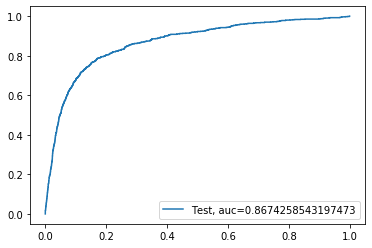

In [133]:
#Training the data with above parameters

preds_L2Search = searchCV.predict(X_test1)
preds_L2Search_probs = searchCV.predict_proba(X_test1)[:,1]

print(classification_report(y_test, preds_L2Search))
accuracy = metrics.accuracy_score(y_test, preds_L2Search)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_L2Search_probs)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

In [134]:
X_test1.columns

Index(['const', 'arpu_6', 'onnet_mou_7', 'offnet_mou_8', 'roam_og_mou_7',
       'roam_og_mou_8', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_8', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8',
       'std_og_mou_7', 'spl_og_mou_8', 'og_others_7', 'og_others_8',
       'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8',
       'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_6',
       'std_ic_t2f_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_8', 'isd_ic_mou_8',
       'ic_others_6', 'ic_others_7', 'ic_others_8', 'total_rech_num_7',
       'total_rech_num_8', 'max_rech_amt_7', 'last_day_rch_amt_8',
       'vol_2g_mb_6', 'vol_2g_mb_8', 'vol_3g_mb_6', 'monthly_2g_6',
       'monthly_2g_7', 'monthly_2g_8', 'aon', 'aug_vbc_3g', 'jun_vbc_3g',
       'rech_days_left_7', 'rech_days_left_8'],
      dtype='object')

### Key Features Obtained from this model :- 

       'arpu_6', 'onnet_mou_7', 'offnet_mou_8', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2m_mou_7',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_8', 'std_og_t2f_mou_8',
       'std_og_mou_7', 'spl_og_mou_8', 'og_others_8', 'loc_ic_t2t_mou_6',
       'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8',
       'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8',
       'spl_ic_mou_6', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_6',
       'ic_others_7', 'ic_others_8', 'total_rech_num_7', 'total_rech_num_8',
       'max_rech_amt_7', 'last_day_rch_amt_8', 'vol_2g_mb_6', 'vol_2g_mb_7',
       'vol_2g_mb_8', 'vol_3g_mb_6', 'monthly_2g_6', 'monthly_2g_7',
       'monthly_2g_8', 'aon', 'aug_vbc_3g', 'jun_vbc_3g', 'rech_days_left_7',
       'rech_days_left_8'

# Model 2 - SVM 

In [135]:
# Scaling the dataset
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [136]:
# Splitting the dataset into test and train

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)

Dimension of X_train: (21000, 97)
Dimension of X_test: (9001, 97)


In [137]:
print("Before applying SMOTE, counts of label '1': {}".format(sum(y_train==1)))
print("Before applying SMOTE, counts of label '0': {} \n".format(sum(y_train==0)))

Before applying SMOTE, counts of label '1': 2293
Before applying SMOTE, counts of label '0': 18707 



In [138]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2)
X_train_sm,y_train_sm = sm.fit_sample(X_train,y_train)

In [139]:
print("After applying SMOTE, counts of label '1': {}".format(sum(y_train_sm==1)))
print("After applying SMOTE, counts of label '0': {} \n".format(sum(y_train_sm==0)))

After applying SMOTE, counts of label '1': 18707
After applying SMOTE, counts of label '0': 18707 



### Applying PCA

In [140]:
X_train_sm.shape

(37414, 97)

In [141]:
from sklearn.decomposition import PCA

pca = PCA(random_state=42)
pca.fit(X_train_sm)

PCA(random_state=42)

In [142]:
pca.components_

array([[-1.45500306e-01, -1.42614938e-01, -8.63967319e-02, ...,
         1.52395996e-01,  1.21388914e-01,  7.19003923e-02],
       [ 1.89002318e-01,  2.12887159e-01,  2.21092351e-01, ...,
         4.50330685e-02, -1.74315441e-02, -1.49645132e-02],
       [-6.26281202e-02, -9.35644452e-02, -9.45201169e-02, ...,
         9.30303471e-02,  1.25217572e-01,  9.27014301e-02],
       ...,
       [ 2.59422533e-02,  1.17420213e-01, -1.94747058e-01, ...,
        -1.81805952e-02,  8.06180398e-04,  4.76563630e-03],
       [ 1.48510293e-02, -1.40040625e-02, -7.34517743e-03, ...,
         2.31246256e-04, -5.09516462e-04,  9.17196482e-05],
       [-2.37803672e-03, -1.84202004e-03,  1.94642101e-03, ...,
        -8.44184561e-05,  1.30010858e-04,  2.99295254e-04]])

In [143]:
pca.explained_variance_ratio_

array([8.65828038e-02, 7.40565141e-02, 5.80227798e-02, 5.37369405e-02,
       3.98346811e-02, 3.13993152e-02, 2.69170076e-02, 2.61813369e-02,
       2.53347048e-02, 2.37176432e-02, 2.26238152e-02, 2.24780941e-02,
       2.08321075e-02, 2.00037216e-02, 1.82602547e-02, 1.78572225e-02,
       1.70576931e-02, 1.67741206e-02, 1.60938670e-02, 1.45051058e-02,
       1.37759863e-02, 1.32058581e-02, 1.28837237e-02, 1.24265964e-02,
       1.18217577e-02, 1.15919245e-02, 1.11599184e-02, 1.08661546e-02,
       1.07133082e-02, 9.76092759e-03, 9.26817219e-03, 8.91393559e-03,
       8.76946418e-03, 8.60968956e-03, 8.42144073e-03, 8.11487519e-03,
       7.61812934e-03, 7.56921084e-03, 7.28819395e-03, 7.11300177e-03,
       6.75132389e-03, 6.58976729e-03, 6.40757461e-03, 6.30044438e-03,
       6.18529274e-03, 5.91806013e-03, 5.45328934e-03, 5.37349186e-03,
       4.82604749e-03, 4.53480432e-03, 4.47464474e-03, 4.36310006e-03,
       4.33670510e-03, 4.19415702e-03, 4.13668402e-03, 4.02890111e-03,
      

#### Making a scree plot for the explained variance

In [144]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

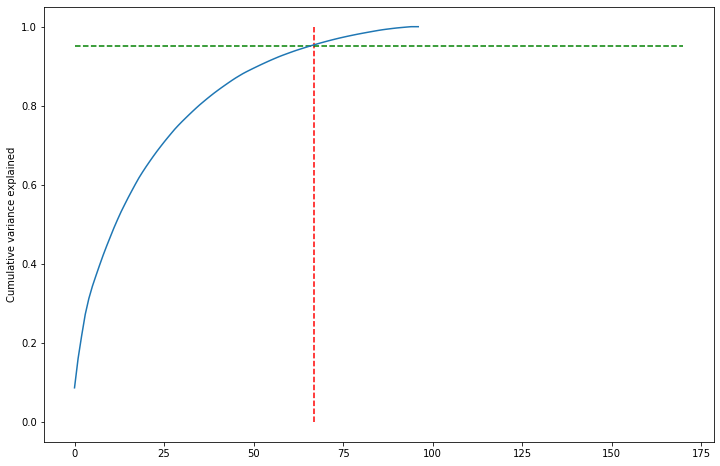

In [145]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=67, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=170, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [146]:
from sklearn.decomposition import IncrementalPCA

pca_final = IncrementalPCA(n_components=67)
X_train_pca = pca_final.fit_transform(X_train_sm)

In [147]:
X_train_pca.shape

(37414, 67)

In [148]:
corrmat = np.corrcoef(X_train_pca.transpose())

In [149]:
corrmat.shape

(67, 67)

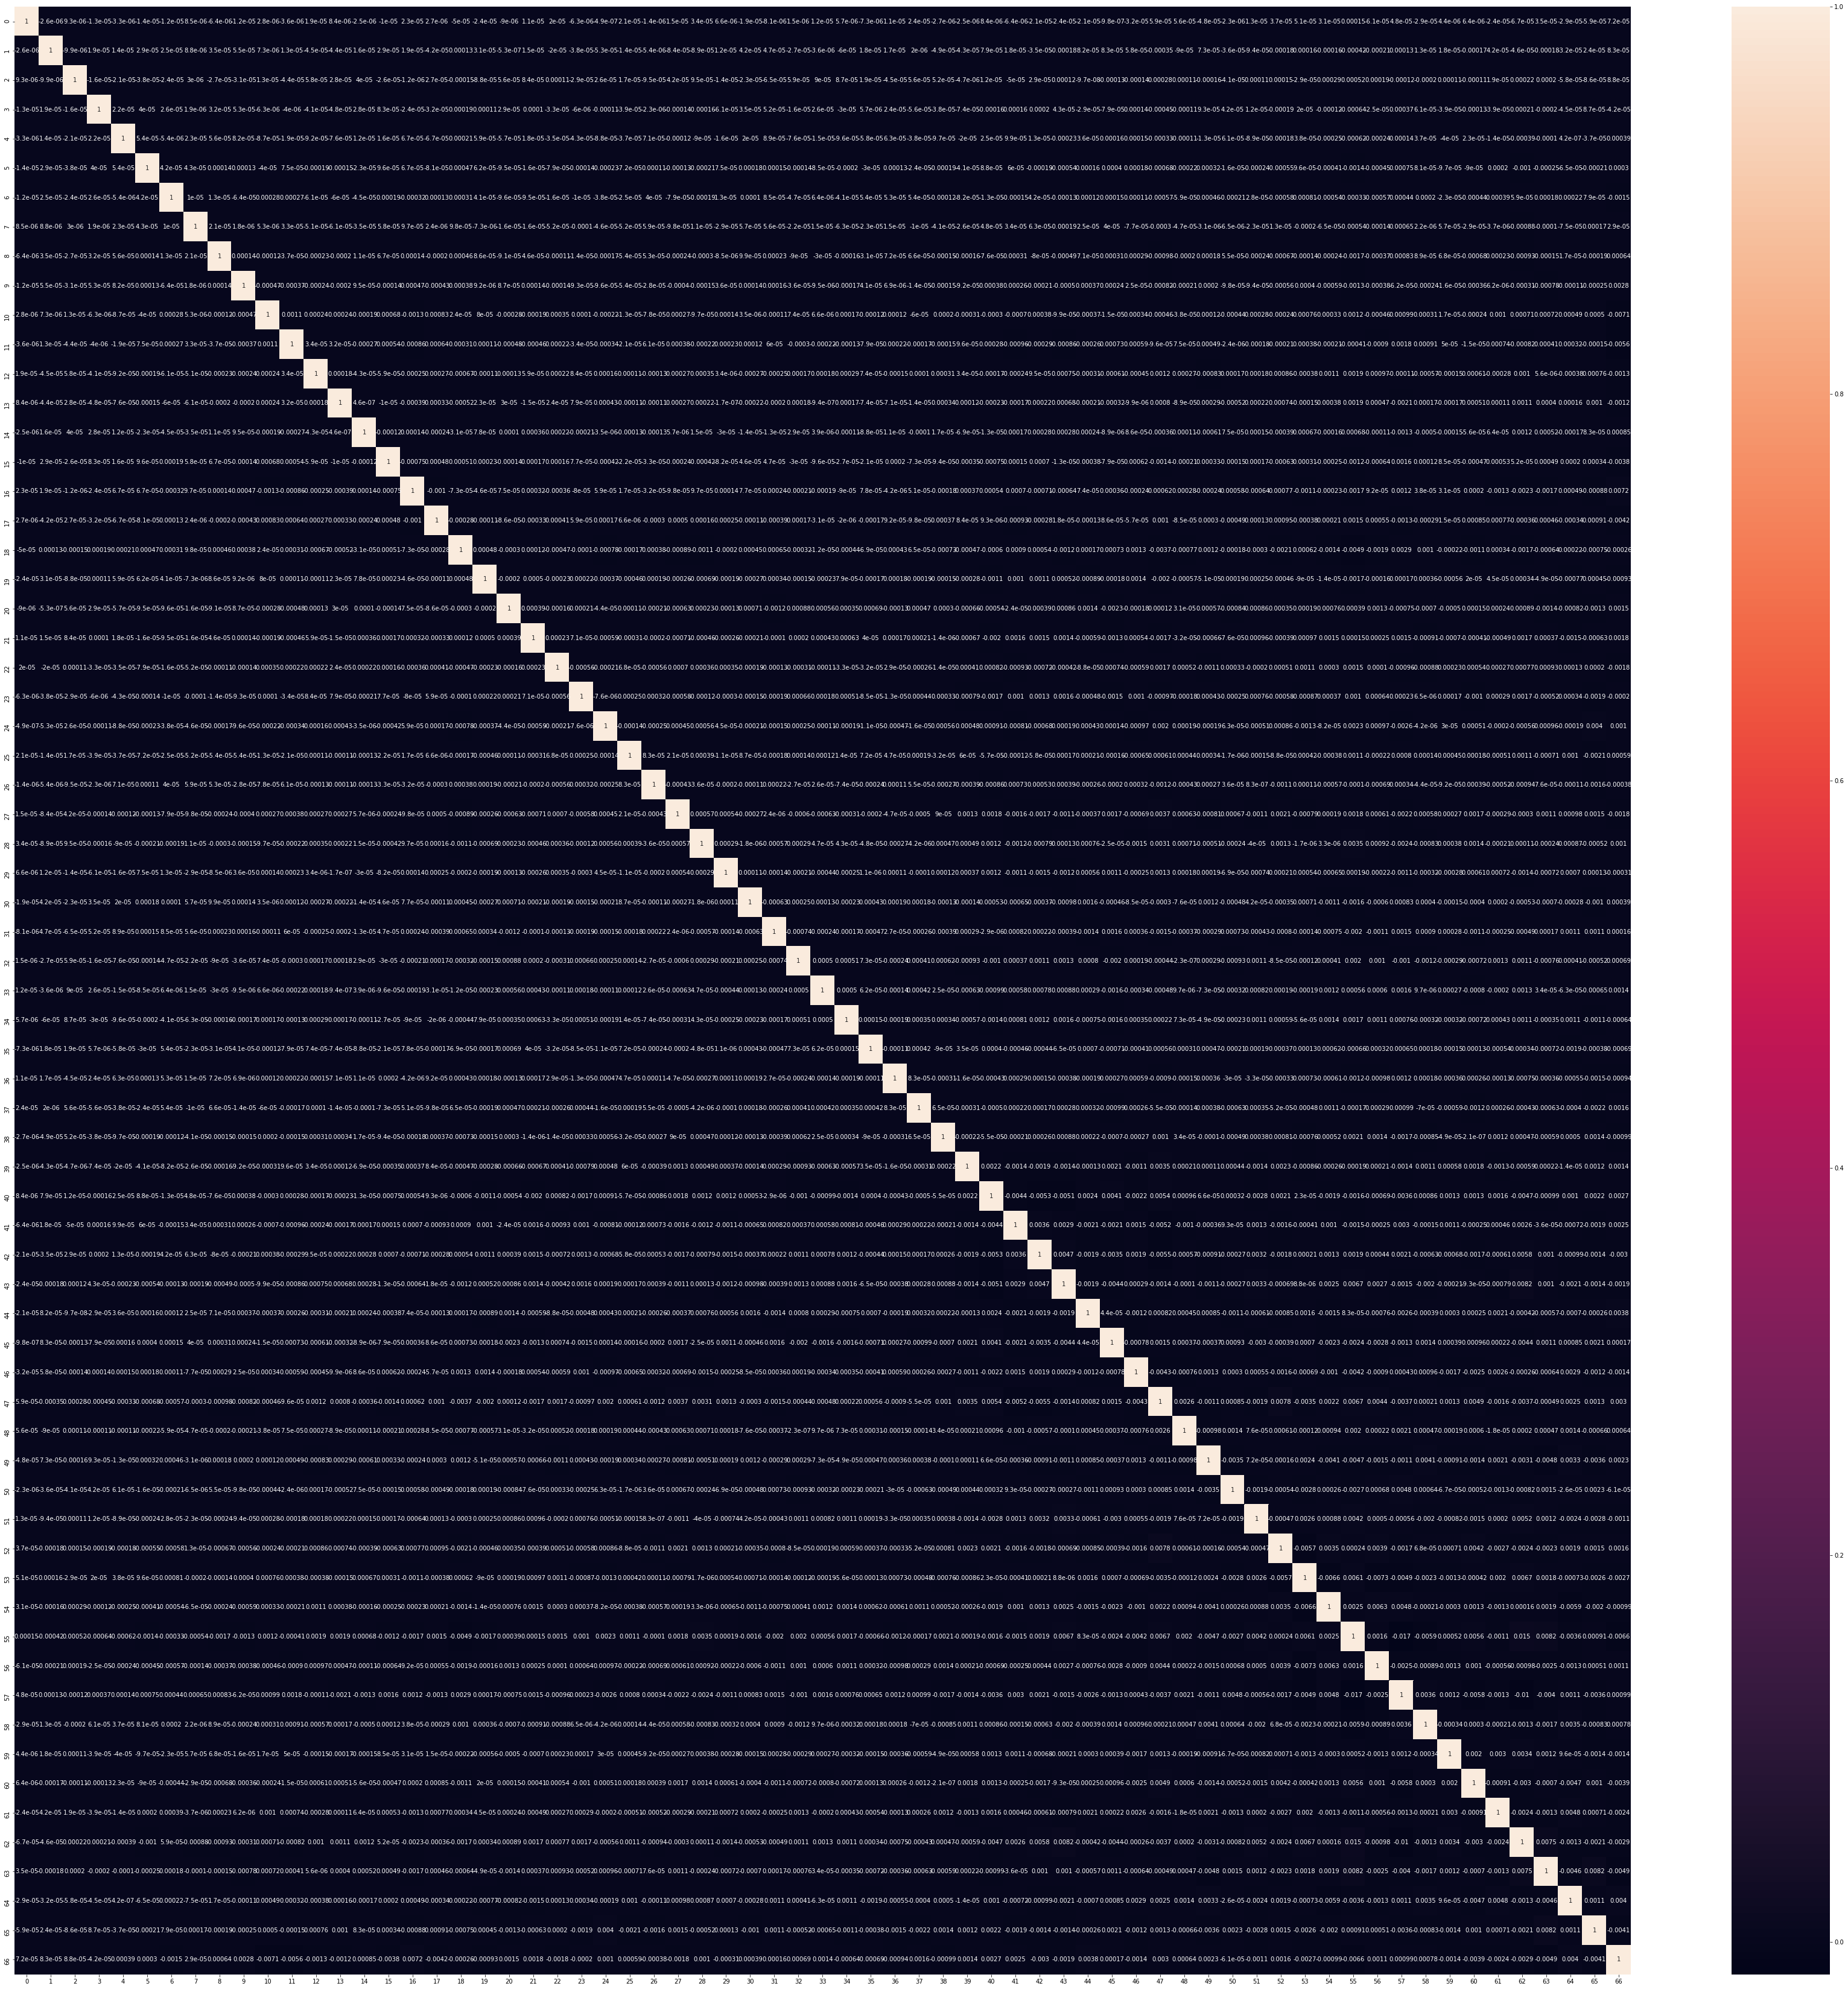

In [150]:
plt.figure(figsize=[60,60])
sns.heatmap(corrmat, annot=True)
plt.show()

In [151]:
X_test_pca = pca_final.transform(X_test)
X_test_pca.shape

(9001, 67)

#### Building a model

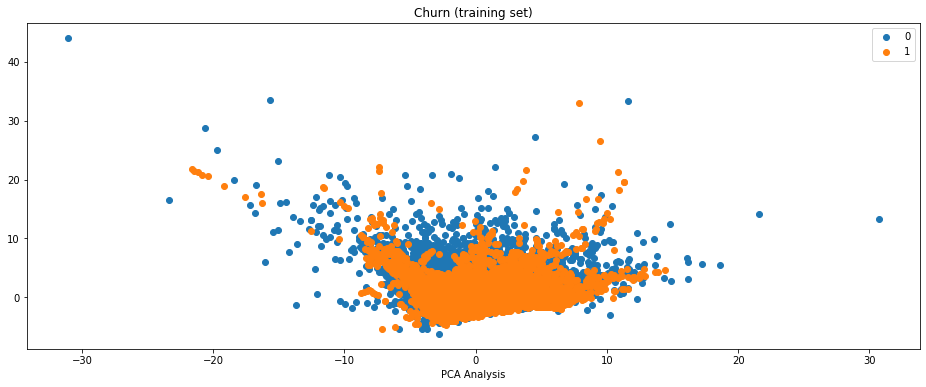

In [152]:
# Plotting PCA output
f, ax = plt.subplots(1, 1)
for i in range(2):
  ax.scatter(X_train_pca[y_train_sm == i, 0], X_train_pca[y_train_sm == i, 1], label=i)
ax.set_xlabel("PCA Analysis")
ax.legend()
f.set_size_inches(16, 6)
ax.set_title("Churn (training set)")
plt.show()

In [153]:
## creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [0.0001, 0.001, 0.01, 0.1],
                     'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


# specify modelb
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train_pca[:10000], y_train_sm[:10000])  

print("The best parameters are %s with a score of %0.2f"
       % (model_cv.best_params_, model_cv.best_score_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 14.5min finished


The best parameters are {'C': 10, 'gamma': 0.01} with a score of 0.91


In [154]:
# model with optimal hyperparameters

# model
model = SVC(C=10, gamma=0.01, kernel="rbf")

model.fit(X_train_pca, y_train_sm)

# metrics
train_score = model.score(X_train_pca, y_train_sm)

y_pred = model.predict(X_test_pca)

In [155]:
print(train_score)

0.9461698829315229


              precision    recall  f1-score   support

           0       0.96      0.89      0.92      8028
           1       0.43      0.69      0.53       973

    accuracy                           0.87      9001
   macro avg       0.69      0.79      0.73      9001
weighted avg       0.90      0.87      0.88      9001

Accuracy for the test dataset 86.7%
ROC for the test dataset 79.1%


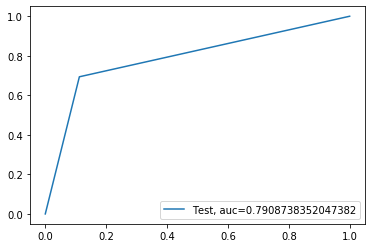

In [156]:
print(classification_report(y_test, y_pred))
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

# Model 3 - Decision Tree

In [157]:

# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

dt_pca = DecisionTreeClassifier(max_depth=10)
dt_pca.fit(X_train_pca, y_train_sm)

DecisionTreeClassifier(max_depth=10)

In [158]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_pred_pca = dt_pca.predict(X_test_pca)

# Printing classification report
print(classification_report(y_test, y_pred_pca))

              precision    recall  f1-score   support

           0       0.95      0.81      0.88      8028
           1       0.29      0.63      0.40       973

    accuracy                           0.79      9001
   macro avg       0.62      0.72      0.64      9001
weighted avg       0.88      0.79      0.82      9001



In [159]:
print(confusion_matrix(y_test,y_pred_pca))
print(accuracy_score(y_test,y_pred_pca))

[[6531 1497]
 [ 356  617]]
0.7941339851127652


# Model 4 - Random Forest

In [160]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

rfc.fit(X_train_pca, y_train_sm)

RandomForestClassifier()

In [161]:
# Making predictions
y_pred_rf = rfc.predict(X_test_pca)

In [162]:
print(classification_report(y_test,y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      8028
           1       0.48      0.50      0.49       973

    accuracy                           0.89      9001
   macro avg       0.71      0.72      0.71      9001
weighted avg       0.89      0.89      0.89      9001

[[7504  524]
 [ 489  484]]


In [163]:
print(accuracy_score(y_test, y_pred_rf))

0.8874569492278636


### Hyper Parameter Tuning

In [164]:
# GridSearchCV to find optimal n_estimators
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True)
rf.fit(X_train_pca, y_train_sm)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(2, 20, 5)}, return_train_score=True,
             scoring='accuracy')

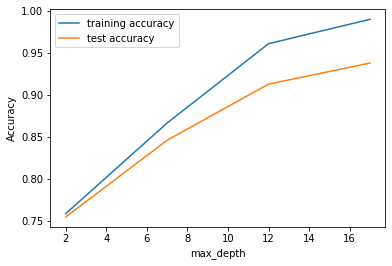

In [165]:
scores = rf.cv_results_

# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [171]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=10)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, n_jobs=-1,
                   scoring="accuracy",return_train_score=True,verbose=5)
rf.fit(X_train_pca, y_train_sm)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed: 22.4min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 26.0min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(max_depth=10), n_jobs=-1,
             param_grid={'n_estimators': range(100, 1500, 400)},
             return_train_score=True, scoring='accuracy', verbose=5)

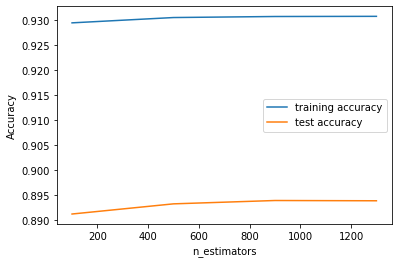

In [172]:
# plotting accuracies with n_estimators
scores = rf.cv_results_

plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [173]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=10)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, n_jobs=-1,
                   scoring="accuracy",return_train_score=True)
rf.fit(X_train_pca, y_train_sm)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_depth=10), n_jobs=-1,
             param_grid={'max_features': [4, 8, 14, 20, 24]},
             return_train_score=True, scoring='accuracy')

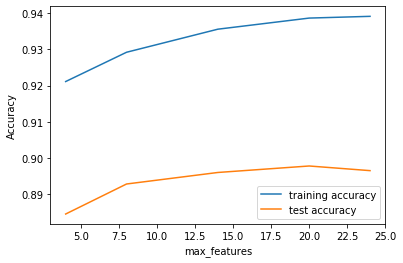

In [174]:
# plotting accuracies with max_features
scores = rf.cv_results_

plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [175]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, n_jobs=-1,
                   scoring="accuracy",return_train_score=True, verbose = 20)
rf.fit(X_train_pca, y_train_sm)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  2

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_leaf': range(100, 400, 50)},
             return_train_score=True, scoring='accuracy', verbose=20)

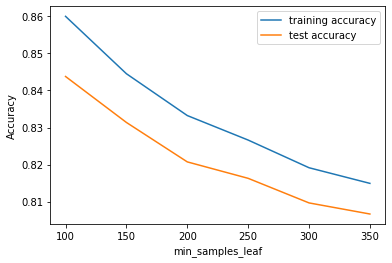

In [176]:
# plotting accuracies with min_samples_leaf
scores = rf.cv_results_

plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [178]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, n_jobs=-1,
                   scoring="accuracy",return_train_score=True, verbose=10)
rf.fit(X_train_pca, y_train_sm)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  5.4min remaining:   35.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.0min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_split': range(200, 500, 50)},
             return_train_score=True, scoring='accuracy', verbose=10)

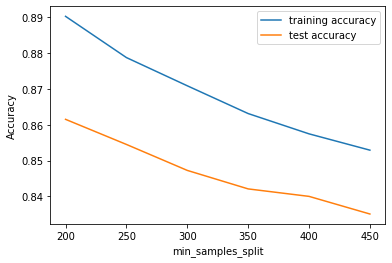

In [179]:
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [180]:
# Create the parameter grid based on the results of random search 
#param_grid = {
#    'max_depth': [4,8,10],
#    'min_samples_leaf': range(100, 150),
#    'min_samples_split': range(200, 250),
#    'n_estimators': [100,800, 900], 
#    'max_features': [5, 10]
#}
# Create a based model
#rf = RandomForestClassifier()
# Instantiate the grid search model
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                          cv = 3, n_jobs = -1,verbose = 1)

In [181]:
#grid_search.fit(X_train_lasso, y_train_sm)

In [186]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=20, 
                             min_samples_split=50,
                             max_features=25,
                             n_estimators=500, n_jobs=-1, verbose=1)

In [187]:
rfc.fit(X_train_pca,y_train_sm)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.5min finished


RandomForestClassifier(max_depth=10, max_features=25, min_samples_leaf=20,
                       min_samples_split=50, n_estimators=500, n_jobs=-1,
                       verbose=1)

In [188]:
predictions = rfc.predict(X_test_pca)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


In [189]:
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix

In [190]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      8028
           1       0.39      0.69      0.50       973

    accuracy                           0.85      9001
   macro avg       0.67      0.78      0.70      9001
weighted avg       0.90      0.85      0.87      9001



In [191]:
print(accuracy_score(y_test, predictions))

0.847350294411732


# Model 5 - XGBoosting

In [192]:
# fit model on training data with default hyperparameters
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

model = XGBClassifier()
model.fit(X_train_pca, y_train_sm)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [193]:
# make predictions for test data
# use predict_proba since we need probabilities to compute auc
y_pred = model.predict_proba(X_test_pca)
y_pred[:10]

array([[1.8436539e-01, 8.1563461e-01],
       [7.9319251e-01, 2.0680749e-01],
       [9.9945420e-01, 5.4581510e-04],
       [9.6913111e-01, 3.0868862e-02],
       [9.9657571e-01, 3.4242643e-03],
       [9.7968286e-01, 2.0317113e-02],
       [9.9473947e-01, 5.2605253e-03],
       [6.9987190e-01, 3.0012813e-01],
       [9.7706211e-01, 2.2937914e-02],
       [9.4504339e-01, 5.4956641e-02]], dtype=float32)

In [194]:
# evaluate predictions
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 85.97%


#### Hyper Parameter Tuning

In [195]:
# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 10,
                        n_jobs=-1,
                        return_train_score=True)   

In [196]:
model_cv.fit(X_train_pca, y_train_sm)    

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  2.7min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  3.2min remaining:   38.5s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.7min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [197]:
cv_results = pd.DataFrame(model_cv.cv_results_)

In [198]:
# convert parameters to int for plotting on x-axis
cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')
cv_results['param_subsample'] = cv_results['param_subsample'].astype('float')
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      36.012962      0.117709         0.156576        0.008803   
1      47.049495      3.366968         0.152490        0.003850   
2      56.339071      0.177872         0.187895        0.033118   
3      29.526274      0.347055         0.185669        0.027137   
4      45.875396      0.859115         0.164745        0.019327   

   param_learning_rate  param_subsample  \
0                  0.2              0.3   
1                  0.2              0.6   
2                  0.2              0.9   
3                  0.6              0.3   
4                  0.6              0.6   

                                     params  split0_test_score  \
0  {'learning_rate': 0.2, 'subsample': 0.3}           0.915953   
1  {'learning_rate': 0.2, 'subsample': 0.6}           0.916242   
2  {'learning_rate': 0.2, 'subsample': 0.9}           0.916581   
3  {'learning_rate': 0.6, 'subsample': 0.3}           0.916865   
4  {'learning_rate': 0.6, 'subsample': 0.6}           0.922323   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.925169           0.925350         0.922157        0.004388   
1           0.925069           0.925183         0.922165        0.004188   
2           0.925375           0.925143         0.922366        0.004092   
3           0.924598           0.922411         0.921291        0.003254   
4           0.936143           0.933321         0.930595        0.005962   

   rank_test_score  split0_train_score  split1_train_score  \
0                5            0.938181            0.934629   
1                4            0.939670            0.935502   
2                3            0.939334            0.935730   
3                6            0.951050            0.949728   
4                2            0.960689            0.958815   

   split2_train_score  mean_train_score  std_train_score  
0            0.934272          0.935694         0.001765  
1            0.935709          0.936961         0.001918  
2            0.936668          0.937244         0.001527  
3            0.949381          0.950053         0.000719  
4            0.958060          0.959188         0.001105

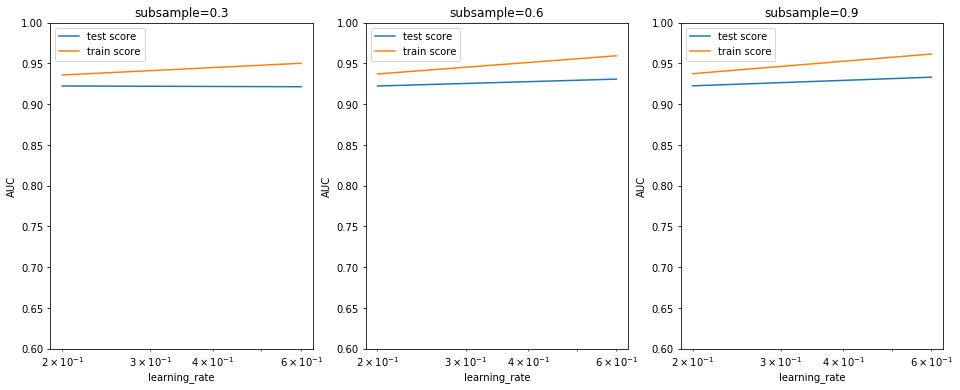

In [199]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [200]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train_pca, y_train_sm)

[21:53:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.6},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [201]:
# predict
y_pred = model.predict_proba(X_test_pca)
y_pred[:10]

array([[1.8436539e-01, 8.1563461e-01],
       [7.9319251e-01, 2.0680749e-01],
       [9.9945420e-01, 5.4581510e-04],
       [9.6913111e-01, 3.0868862e-02],
       [9.9657571e-01, 3.4242643e-03],
       [9.7968286e-01, 2.0317113e-02],
       [9.9473947e-01, 5.2605253e-03],
       [6.9987190e-01, 3.0012813e-01],
       [9.7706211e-01, 2.2937914e-02],
       [9.4504339e-01, 5.4956641e-02]], dtype=float32)

In [202]:
# roc_auc
auc = sklearn.metrics.roc_auc_score(y_test, y_pred[:, 1])
auc

0.8597364261057521

### Predictive Analysis :-

    - A Logistic Regression with L2 Penalty gave Accuracy for the test dataset 80.7% and a ROC of 86.7%.
    - We then applied PCA for dimentionality reduction and removal of multicollinearity.
    - SVC Classifier post PCA gave a 94% Training accuracy (after hyperparameter tuning) and 86.7% test accuracy and a ROC  of 79.1%
    - Single Decision Tree (w/ PCA) gave a test accuracy of 79%.
    - A Random forest (w/ PCA) improved the accuracy of Decision Tree to give a 84.7% test accuracy.
    - XGBoost Classifier also gave an AUC of 85.97%.
    - As a conlusion, The SVC Classifier gives out best accuracy of all, but it would be recommended to consider an ensemble of all the trained models contributing equally to the final prediction. This will ensure that the shortcomings of one model are being addressed by the others.

### Conclusion & Informational Analysis:- 

    -  The customers who churn are more likely to not generate revenue in the 3rd consecutive month 
    -  The non-churn customers tend to provide consistent revenue even in the 3rd month while the revenue from 
       the churn customers starts to decrease.
    -  The consistency of non-churn customers is same for all three months, this could mean that the AON 
       (Age on Network) of these customers could be higher (i.e. the customers are old customers) as they've 
       found a suitable plan for them and are choosing the same every month.
    -  We can observe that the customers who have stayed longer with the network are more likely to stay .
    -  We observe a drastic drop in onnet and offnet usage in the churning customers and is consistent for 
       the customers that do not churn. Even in the good phase, the usage is seen to be reducing in the 2nd 
       month for churn customers. This usage can be a potential indicator for churning.
    -  While the decrease in usage is low from 6th to 7th month, the drop is huge in usage for churn customers 
       from 7th to 8th month.